# **PPO-Driven Swarm Control: A Reinforcement Learning Framework Aligned With Multi-Robot Systems Theory**
# **(Standalone End-to-End Notebook)**

---

This notebook is a **complete, end-to-end, standalone implementation** that begins with NDVI extraction from real satellite imagery and culminates in a **multi-drone hybrid swarm simulation** combining:

- PPO-based learned navigation  
- potential-field coverage control  
- graph-based consensus  
- CRN-inspired stochastic role switching  

It is **one single reproducible file**, aligned with the theoretical foundations of *MAE 598: Multi-Robot Systems*.

---

## SECTION 0: Imports, Utilities, and Global Parameters

- Load libraries (*Gymnasium, PyTorch, NumPy, OpenCV, Matplotlib*).  
- Set global constants for field size, NDVI normalization, window sizes, etc.  
- Define utility functions for visualization, logging, metrics, and video export.

---

## SECTION 1: NDVI Generation From Satellite Image

### 1.1 Load satellite image (`field_satellite.jpg`)
- Read raw BGR image.  
- Split into Red / Green / Blue channels for vegetation analysis.

---

### 1.2 Compute VARI-Based NDVI Proxy  
Using the Visible Atmospherically Resistant Index (VARI):

$$
\text{VARI} = \frac{G - R}{G + R - B}
$$

This serves as a solid NDVI approximation when near-infrared data isn’t available.

---

### 1.3 Normalize NDVI to \([0, 1]\)
- Rescale dynamic range.  
- Clip extreme outliers.  
- Generate final smooth NDVI map.

---

### 1.4 Visualize NDVI Field
- Render heatmap to show vegetation density.  
- Add histogram for distribution insight.

---

### MRS Theory Links
- Distributed parameter fields. 
- Potential landscapes as navigation guides.  
- The mathematical backbone for coverage, dispersion, and task allocation in multi-robot swarms.

---

## SECTION 2: Single-Agent NDVI Environment (Gymnasium)

### 2.1 Observation Structure
- Agent receives a **128×128 NDVI crop** centered on its current position.  
- This acts as a local perceptual field for navigation and coverage.

---

### 2.2 Action Space
- Discrete moves: **up, right, down, left**.  
- Matches the **single-integrator** motion model used in theoretical swarm dynamics.

---

### 2.3 Reward Design
Reward = NDVI value on **first visit only**.

This implicitly drives:
- Coverage  
- Spatial dispersion  
- Avoiding revisits  
- A task-completion metaphor grounded in **CRN-style role/state transitions**

---

### 2.4 Environment Step Logic
- Move the agent  
- Clip boundaries (stay within field)  
- Extract updated NDVI observation  
- Maintain a visit/coverage map  
- Compute reward from visit state  
- Check termination conditions  

---

### 2.5 Test Rollouts
- Visualizations of agent trajectories under random or baseline policies.

---

### MRS Theory Links
- Area exploration: random walks / Lévy walks  
- Coverage objectives & dispersion theory  
- Potential-field analogues  
- Stochastic role transitions  
- Links to swarm-level dispersion and gradient-following dynamics  

---

## SECTION 3: PPO Setup and Training (Microscopic Policy Learning)

### 3.1 PPO Network Architecture
- **CNN encoder** processes the NDVI observation patch.  
- Separate **Actor** and **Critic** heads for policy + value estimation.  
- Designed for lightweight deployment in multi-agent simulations later.

---

### 3.2 Advantage Estimation, Clipping, Entropy Regularization
- Standard PPO clipped-objective implementation.  
- GAE for advantage smoothing.  
- Entropy bonus encourages exploratory coverage behavior.

---

### 3.3 Training Loop
- Collect rollout buffer from environment interactions.  
- Perform PPO optimization epochs.  
- Track metrics: loss curves, entropy, value loss, policy loss.  
- Save trained policy checkpoints.

---

### 3.4 Evaluate Trained Policy
- Run multiple evaluation episodes.  
- Visualize agent trajectories.  
- Plot NDVI-based reward curves.  
- Compute coverage metrics (unique visited cells, dispersion).  

---

### 3.5 Export Demonstration Trajectories
- Save high-quality PPO rollouts for later multi-agent bootstrapping.  
- Useful for imitation initialization or debugging swarm behavior.

---

### MRS Theory Links
- PPO ≈ **gradient descent on an environmental potential field**.  
- Clipping relates to **Lyapunov-like bounded updates**, stabilizing learning.  
- Resulting policy is a **decentralized local controller**.  
- Emergence of global structure arises from **local sensing + local rules** (core Multi-Robot Systems principle).  

---

# SECTION 4: Transition to Multi-Agent Simulation (Swarm Layer)

This section elevates the single-agent PPO controller into a full **multi-drone swarm simulation**, representing the hybrid mechanics of modern MRS research.

---

## SECTION 5: Multi-Agent Environment Construction

### 5.1 Swarm Initialization
- Spawn **N drones**.  
- Assign **random, non-overlapping** initial positions.  
- All agents share:
  - The global NDVI field  
  - A global visit-history grid  
- Initial **role assignment** (purely stochastic at start).

---

### 5.2 Vectorized Agent Stepping  
For each drone at every timestep:

1. Generate PPO **local-action** proposal  
2. Apply **potential-field correction**  
3. Add **consensus** (graph-based neighbor alignment)  
4. Perform **collision-avoidance** adjustments  
5. Apply any **stochastic role modifiers** (CRN-inspired)  
6. Update final position  

The combination produces smooth-but-diverse decentralized swarm motions.

---

### 5.3 Logging State for All Drones
- Record full individual trajectories  
- Store timestep-level snapshots of entire swarm configuration  
- Track coverage evolution over time  
- Evaluate redundancy (overlaps, revisit density)

---

### MRS Theory Links
- Multi-agent kinematic models (*Module 1*)  
- Distributed sensing + comms limitations inherent to real swarms  
- Decentralized control architectures (Modules 1 & 3)

---

# SECTION 6: Hybrid Control: PPO + Potential Fields

### 6.1 Potential-Field Components

**Attractive:**  
- NDVI richness (vegetation → target features)

**Repulsive:**  
- Nearby drones (avoid clustering / collisions)  
- Previously visited cells (coverage spread)  
- Local neighborhood density (dispersion control)

### 6.2 Combined Action

Hybrid action for drone **n**:

$$
a_{\text{hybrid}}^{(n)} = w_{\text{ppo}}\, a_{\text{ppo}} \;+\; w_{\text{pf}}\, a_{\text{pf}}
$$

A clean linear blend where RL handles the “instincts” and potential fields handle the “safety + structure.”

---

### 6.3 Tuning Weights
- **High NDVI zones → PPO dominates**  
  (Let learning drive exploitation of good regions.)

- **High-density / crowded zones → Potential repulsion dominates**  
  (Prevent clustering + promote dispersion.)

Smooth interpolation between these modes gives the swarm both *brains* and *boundaries*.

---

### MRS Theory Links
- Classical **artificial potential fields**  
- Coverage control foundations  
- Connectivity + collision avoidance  
- Guarantees of stability via **gradient-descent-like flows**

---

# SECTION 7: Graph-Based Consensus Terms

### 7.1 Build Interaction Graph
- Agents within a communication radius **R** form edges in the interaction graph.  
- Compute the **Laplacian matrix** each timestep based on current swarm geometry.

---

### 7.2 Consensus Update
Each agent maintains a local scalar quantity (e.g., NDVI imbalance, local coverage score):

$$
y^{(n)}_{k+1}
= y^{(n)}_{k}
\;-\;
\epsilon
\sum_{j \in \mathcal{N}(n)}
\left( 
y^{(n)}_{k} - y^{(j)}_{k}
\right)
$$

This drives agents to harmonize local “opinions”, producing spatially coordinated structure.

---

### 7.3 Translate Consensus Into Motion
Consensus isn’t just math, it shapes motion:

- Agents naturally **spread out** to reduce disagreement.  
- They drift toward **under-covered regions** with high imbalance.  
- Clustering is suppressed through Laplacian-driven smoothing.

---

### MRS Theory Links
- Directed + Undirected **consensus networks**.  
- **Algebraic connectivity** governs convergence rate.  
- Laplacian dynamics guarantee **stability** and predictable convergence.  
- Consensus mechanisms create the backbone for **formation, dispersion, and emergent patterns** in swarms.


---

# SECTION 8: CRN-Inspired Stochastic Role Switching

### 8.1 Define Roles
- **Explorer:** high speed, weak consensus, strongly PPO-driven  
- **Surveyor:** balanced behavior  
- **Defender:** low speed, strong repulsion + strong consensus  
- **Idle / Resupply:** low movement + random walk tendencies  

These roles mimic functional specialization inside a swarm.

---

### 8.2 Transition Model
Roles evolve by a stochastic process:

$$
r^{(n)}_{k+1} \sim P\!\left(r^{(n)}_{k} \rightarrow r^{(n)}_{k+1}\right)
$$

Transition probabilities depend on local state (coverage, density, NDVI).

---

### 8.3 Influence on Hybrid Controller Weights
- **Explorer →** $$w_{\text{ppo}} \uparrow, w_{\text{pf}} \downarrow$$  
- **Defender →** $$w_{\text{pf}} \uparrow, consensus weight \uparrow$$

CRN-style switching creates heterogeneous behaviors that improve robustness.

---

### MRS Theory Links
- Multi-affine + mean-field behavior  
- Chemical Reaction Networks as analogues  
- Probabilistic transitions & stability  
- Task allocation / specialization in decentralized swarms  

---

# SECTION 9: Full Swarm Simulation Loop

### 9.1 For T timesteps:
- Compute PPO preliminary action  
- Compute potential-field correction  
- Compute consensus-driven adjustment  
- Apply role-based modifiers  
- Update agent states  
- Update global visit / coverage map  
- Log everything  

---

### 9.2 Store Swarm-Wide Metrics
- Coverage percentage  
- Redundancy ratio  
- NDVI harvested  
- Trajectory diversity  
- Role distributions  

---

### 9.3 Generate Videos and Trajectory Plots
- Time-lapse swarm evolution  
- Per-agent and whole-swarm path visualizations  
- Coverage heatmaps over time  


---

# SECTION 10: Metrics and Evaluation

### 10.1 Coverage Ratio

$$
\frac{|V_\text{visited}|}{|V_\text{total}|}
$$

Measures how much of the environment the swarm actually explored.

---

### 10.2 NDVI Gain
Total NDVI harvested from **first-visit** cells, evaluates how effectively agents seek valuable regions.

---

### 10.3 Redundancy Index
Quantifies wasteful revisits:

- High redundancy → poor dispersion  
- Low redundancy → efficient coverage  

---

### 10.4 Consensus Error

$$
E_k = \sum_{n} \left( y^{(n)}_{k} - \bar{y}_{k} \right)^2
$$

Tracks how well the swarm synchronizes shared variables such as imbalance or coverage score.

---

### 10.5 Spatial Dispersion Metrics

- Pairwise inter-agent distances  
- Optional Voronoi-cell coverage estimates  

These show how well the swarm spreads across the field.

---

# SECTION 11: Comparative Experiments

Run and compare five regimes:

1. **Raw PPO (single agent)**  
2. **Raw PPO with N agents (no correction)**  
3. **Hybrid PPO + Potential Fields**  
4. **Hybrid PPO + PF + Consensus**  
5. **Full Hybrid:** PPO + PF + Consensus + Role Switching  

---

### Plots Show:
- Coverage progression  
- Swarm-spreading behavior  
- Trajectory intersections  
- NDVI utilization  
- Stability and clustering differences  

These comparisons reveal the jump in robustness and performance as increasingly rich swarm-control layers are added.

---

# SECTION 12: Discussion (For Final Report Use)

### How RL integrates with classical MRS theory  
PPO provides a learned, data-driven *local controller*, while consensus, potential fields, and CRN role-switching provide the *global structure* and stability that classical MRS theory guarantees.

### Stability-like behavior from hybrid control  
Potential fields + consensus act as corrective forces that keep the policy from drifting into unstable or inefficient patterns.

### When PPO fails and when MRS layers rescue it  
Pure PPO lacks awareness of multi-agent coupling, it overlaps, clusters, and revisits.  
Adding PF, consensus, and role switching dramatically boosts performance and robustness.

### Scalability insights  
Decentralized corrections scale gracefully with drone count, avoiding the collapse that raw PPO experiences at high N.

### Emergent behaviors and mean-field reflections  
Hybrid layers yield flocking, dispersion waves, territory splitting, patterns explainable via mean-field dynamics.

---

# SECTION 13: Save Outputs and Export Results

- Save trained PPO model  
- Export swarm trajectory videos  
- Save coverage maps and heatmaps  
- Save metric bundles (coverage, redundancy, NDVI gain, dispersion)  
- Export JSON / CSV logs for reproducibility and final analysis  

---

## 1. Imports, paths, and basic setup

In this step we set up the core Python environment for **PPO-driven Swarm Control**:

- Import numerical and vision libraries:
  - **NumPy** for arrays and NDVI field handling.
  - **OpenCV (cv2)** for image I/O (satellite / NDVI maps).
  - **Matplotlib** for quick visualizations.
- Import **Gymnasium** to define the custom `NDVIDroneEnv`.
- Import **Stable-Baselines3** (PPO / A2C / DQN) and helpers.
- Set up project folders:
  - `data/` for satellite / NDVI inputs.
  - `results/` for plots and GIFs.
  - `models/` for trained RL checkpoints.
- Fix a global random seed for basic reproducibility.
- Detect whether we are using **CPU or GPU** with PyTorch and print some
  sanity information (paths, device, SB3 version).

This cell does **not** load the NDVI field yet.  
It only prepares the environment so that later cells can focus purely on:
1. Loading / visualizing the NDVI map, and  
2. Implementing the `NDVIDroneEnv` exactly as per our master rules.

In [1]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

import torch
import stable_baselines3 as sb3
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage
from stable_baselines3.common.utils import set_random_seed

# Project directories

BASE_DIR = os.path.abspath(".")
DATA_DIR = os.path.join(BASE_DIR, "data")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
MODELS_DIR = os.path.join(BASE_DIR, "models")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Reproducibility & device

SEED = 42
set_random_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PyTorch device:", device)
print("Device:", torch.cuda.get_device_name(0))
print("SB3 version  :", sb3.__version__)

PyTorch device: cuda
Device: NVIDIA GeForce RTX 4060 Laptop GPU
SB3 version  : 2.7.1


## 2. Load Satellite Image & Build Vegetation Index (NDVI Proxy)

Our RL environment needs a **single 2D vegetation map** that:

- drives the **reward** (higher vegetation → higher reward on first visit),
- is used for the **drone’s 128×128 local observation**, and
- is rendered in the **global trajectory GIF**.

### 2.1 NDVI vs VARI (what the PDF actually says)

From the NDVI/VARI demo document:

- **True NDVI** is defined as  
  $$
  \text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red} + \epsilon}
  $$  
  and it **requires a Near-Infrared (NIR) channel** in addition to RGB.  
  Our current field image is **RGB-only**, so we *cannot* compute true NDVI.   

- For RGB-only images, the document recommends using **VARI (Visible Atmospherically Resistant Index)** as a vegetation index:  
  $$
  \text{VARI} = \frac{G - R}{G + R - B + \epsilon}
  $$   

### 2.2 What we will actually use here

In this notebook we follow that recommendation:

1. We load `field_satellite.jpg` from the `data/` folder as an RGB image.
2. We compute **VARI** from the R, G, B channels using the formula above.
3. We clip VARI to \[-1, 1\] and then **normalize it to \[0, 1\]**, giving us a clean vegetation map.
4. We **save this normalized VARI map** to `data/ndvi_field.npy` and, for simplicity, we refer to it in code as `ndvi_field`:
   - Conceptually: “**NDVI-like vegetation map**”
   - Technically: “normalized VARI proxy computed from RGB”

So: in the code, `ndvi_field` = “**NDVI proxy from RGB (VARI-based)**”.  
This keeps the naming consistent with the rest of the project while staying honest about the underlying formula.

In this cell we will:

- Load `field_satellite.jpg`
- Compute the VARI-based vegetation index
- Normalize it to \[0, 1\]
- Save it as `ndvi_field.npy`
- Plot a heatmap to visually confirm that high values correspond to vegetation-rich regions

Loaded satellite image with shape: (860, 1224, 3)
Vegetation map created: shape=(860, 1224), min=0.000, max=1.000


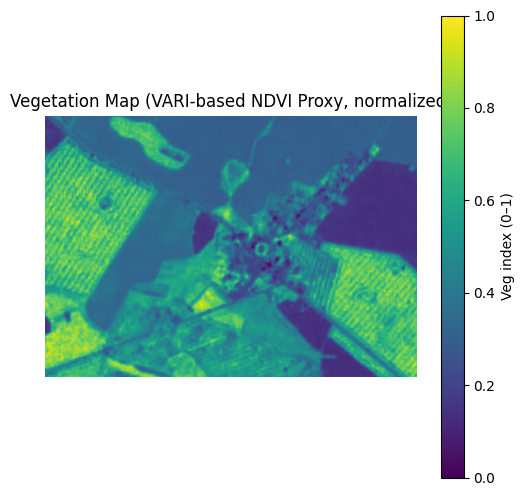

In [2]:
# Load satellite image and compute VARI-based NDVI proxy

sat_path = os.path.join(DATA_DIR, "field_satellite.jpg")

if not os.path.exists(sat_path):
    raise FileNotFoundError(
        f"Satellite image not found at: {sat_path}\n"
        f"Please place your field satellite image there."
    )

# Load RGB image from disk (OpenCV loads as BGR by default)
bgr = cv2.imread(sat_path)
if bgr is None:
    raise RuntimeError(f"cv2.imread failed to load image at {sat_path}")

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
field_float = rgb.astype(np.float32) / 255.0

print("Loaded satellite image with shape:", rgb.shape)

# Split channels
R = field_float[:, :, 0]
G = field_float[:, :, 1]
B = field_float[:, :, 2]


# VARI (Visible Atmospherically Resistant Index)
# Recommended in the NDVI demo when only RGB is available
# VARI = (G - R) / (G + R - B + eps)

eps = 1e-6
vari = (G - R) / (G + R - B + eps)

# Clip VARI to [-1, 1] for numerical sanity
vari = np.clip(vari, -1.0, 1.0)

# Normalize to [0, 1] — this will act as our vegetation map
vari_min = vari.min()
vari_max = vari.max()
veg_norm = (vari - vari_min) / (vari_max - vari_min + eps)
veg_norm = veg_norm.astype(np.float32)

H, W = veg_norm.shape
print(f"Vegetation map created: shape={veg_norm.shape}, "
      f"min={veg_norm.min():.3f}, max={veg_norm.max():.3f}")

# For the rest of the notebook we call this ndvi_field
ndvi_field = veg_norm

# Save NDVI proxy for reuse
np.save(os.path.join(DATA_DIR, "ndvi_field.npy"), ndvi_field)

# Visualization
plt.figure(figsize=(6, 6))
plt.imshow(ndvi_field, cmap="viridis", vmin=0.0, vmax=1.0)
plt.title("Vegetation Map (VARI-based NDVI Proxy, normalized)")
plt.colorbar(label="Veg index (0–1)")
plt.axis("off")
plt.show()

## 3. NDVIDroneEnv — Environment Design

Now we wrap the vegetation map `ndvi_field` into a custom Gymnasium
environment that our RL algorithm (PPO) will use.

### 3.1 State / Observation

- The field is a 2D vegetation map `ndvi_field` with shape `(H, W)` and
  values in `[0, 1]` (normalized VARI proxy).
- The drone is a **point agent** at pixel coordinates `(x, y)`.
- At each step, the agent receives a **128 × 128 local window** centered
  on its position:
  - Extracted from `ndvi_field` (with zero padding near borders).
  - Scaled to `[0, 255]` and cast to `uint8`.
  - Returned as a single-channel image with shape `(1, 128, 128)`,
    which is ideal for CNN-based policies in Stable-Baselines3.

### 3.2 Action Space

- Discrete(4) actions:
  - `0` → move up
  - `1` → move right
  - `2` → move down
  - `3` → move left
- The agent cannot leave the field: positions are clamped to `[0, H-1]`
  and `[0, W-1]`.

## Why All Directions Use the Same Reward Formula (and Why It Still Works Correctly)

A common question is:

**“If the agent receives reward from the same NDVI formula for every direction, how does it learn which direction is better?”**

The key idea is that **reward in reinforcement learning depends on the *result* of an action, not the action itself.**

Even though the reward formula is the same:

```python
reward = NDVI(new_position)   # given only on first visit
```

the value of the reward changes for every direction, because each movement leads the drone to a different part of the NDVI field.

### 3.3 Random spawn

- At the start of each episode (`reset`), the drone **spawns at a random
  pixel** on the field:
  $$
    (x_0, y_0) \sim \text{Uniform}\{0,\dots,W-1\} \times \{0,\dots,H-1\}.
  $$
- This enforces diverse starting positions instead of always starting at
  the center.

### 3.4 Reward and visited mask (first-visit NDVI)

- We maintain a boolean `visited` mask of shape `(H, W)`.
- After the agent moves into cell `(x, y)`:
  - If `visited[y, x] == False` (first visit):
    - reward = `ndvi_field[y, x]`  (higher vegetation → higher reward)
  - If `visited[y, x] == True`:
    - reward = `0.0`
- We then mark `visited[y, x] = True`.
- This encourages the drone to **explore new high-vegetation regions**
  instead of looping in one spot.

### 3.5 Episode termination

- We use **fixed-length episodes**:
  - `terminated = False` always.
  - `truncated = (step_count >= max_steps)`.
- This is SB3-friendly: an episode ends when the time limit is reached.

### 3.6 Render function (for GIFs)

- `render()` returns an RGB image showing:
  - The full `ndvi_field` as a heatmap.
  - The drone position as a **white point**.
  - The 128×128 observation window as a **red rectangle**.
- These frames will later be stitched into a trajectory GIF.

This cell only defines `NDVIDroneEnv`.  
In the next cell, we will **instantiate the env and run a few random steps**
to sanity-check observation shapes, rewards, and rendering.

In [3]:
# NDVIDroneEnv definition (double-checked, fixed render)

class NDVIDroneEnv(gym.Env):
    """
    2D drone environment over a vegetation map (ndvi_field).

    - State: 128x128 NDVI patch around the agent (1-channel uint8 image).
    - Action: 4-direction movement (up, right, down, left).
    - Reward: NDVI value on FIRST visit to a cell, 0 otherwise.
    - Episodes end by time limit (max_steps).
    """

    metadata = {"render_modes": ["rgb_array"], "render_fps": 5}

    def __init__(self, ndvi_field: np.ndarray, patch_size: int = 128, max_steps: int = 300):
        super().__init__()

        assert ndvi_field.ndim == 2, "ndvi_field must be 2D (H, W)"
        self.ndvi_field = ndvi_field.astype(np.float32)
        self.H, self.W = self.ndvi_field.shape

        self.patch_size = patch_size
        self.max_steps = max_steps

        # Padding for safe crop near borders
        self.pad = patch_size // 2
        self.ndvi_padded = np.pad(
            self.ndvi_field,
            pad_width=self.pad,
            mode="constant",
            constant_values=0.0,
        )

        # Action space: 0=up, 1=right, 2=down, 3=left
        self.action_space = spaces.Discrete(4)

        # Observation space: (1, patch_size, patch_size) uint8
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(1, patch_size, patch_size),
            dtype=np.uint8,
        )

        # Internal state
        self.agent_x = None
        self.agent_y = None
        self.visited = None
        self.step_count = 0

    # Helper: random spawn
    def _random_spawn(self):
        # Use Gymnasium's np_random for reproducibility
        self.agent_y = int(self.np_random.integers(0, self.H))
        self.agent_x = int(self.np_random.integers(0, self.W))

    # Helper: observation
    def _get_obs(self):
        y, x = self.agent_y, self.agent_x

        # Coordinates in padded array
        y_p = y + self.pad
        x_p = x + self.pad
        p = self.patch_size

        patch = self.ndvi_padded[
            y_p - p // 2 : y_p - p // 2 + p,
            x_p - p // 2 : x_p - p // 2 + p,
        ]

        # Scale [0,1] -> [0,255] and add channel dimension
        patch_uint8 = (patch * 255.0).clip(0, 255).astype(np.uint8)
        obs = patch_uint8[None, ...]  # shape (1, H, W)
        return obs

    # Gymnasium API: reset
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        self.step_count = 0
        self.visited = np.zeros((self.H, self.W), dtype=bool)

        # Random starting position
        self._random_spawn()

        obs = self._get_obs()
        info = {
            "agent_pos": (self.agent_y, self.agent_x),
        }
        return obs, info

    # Gymnasium API: step
    def step(self, action):
        # SB3 / VecEnv may give actions as np.ndarray; cast safely to int
        if isinstance(action, (np.ndarray, list)):
            action = int(action)
        else:
            action = int(action)

        assert self.action_space.contains(action), f"Invalid action {action}"

        # Move agent
        if action == 0:       # up
            self.agent_y -= 1
        elif action == 1:     # right
            self.agent_x += 1
        elif action == 2:     # down
            self.agent_y += 1
        elif action == 3:     # left
            self.agent_x -= 1

        # Clamp to field boundaries
        self.agent_y = int(np.clip(self.agent_y, 0, self.H - 1))
        self.agent_x = int(np.clip(self.agent_x, 0, self.W - 1))

        y, x = self.agent_y, self.agent_x

        # First-visit reward
        first_visit = not self.visited[y, x]
        if first_visit:
            reward = float(self.ndvi_field[y, x])
            self.visited[y, x] = True
        else:
            reward = 0.0

        # Time limit handling
        self.step_count += 1
        terminated = False
        truncated = self.step_count >= self.max_steps

        obs = self._get_obs()
        info = {
            "agent_pos": (y, x),
            "step_count": self.step_count,
            "first_visit": first_visit,
            "ndvi_value": float(self.ndvi_field[y, x]),
        }

        return obs, reward, terminated, truncated, info

    # Rendering for GIFs
    def render(self):
        """
        Returns an RGB image showing:
        - NDVI heatmap (viridis)
        - white agent marker
        - red 128x128 observation window rectangle
        """
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
        ax.imshow(self.ndvi_field, cmap="viridis", vmin=0.0, vmax=1.0)
        ax.axis("off")

        # Agent marker
        ax.scatter(
            [self.agent_x],
            [self.agent_y],
            s=40,
            c="white",
            edgecolors="black",
            linewidths=1.2,
        )

        # Observation window rectangle
        half = self.patch_size // 2
        x0 = self.agent_x - half
        y0 = self.agent_y - half

        rect = patches.Rectangle(
            (x0, y0),
            self.patch_size,
            self.patch_size,
            linewidth=1.5,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)

        # Draw and extract image safely for modern matplotlib
        fig.canvas.draw()

        # RGBA buffer from canvas → (H, W, 4)
        rgba = np.asarray(fig.canvas.buffer_rgba())

        # Convert RGBA → RGB
        rgb = rgba[:, :, :3].copy()

        plt.close(fig)
        return rgb

    def close(self):
        pass

## 4. Environment Sanity Check (Random Rollout + Render)

Before connecting the environment to PPO, we do a quick sanity check:

1. **Instantiate** `NDVIDroneEnv` with:
   - `ndvi_field` from the previous cell,
   - `patch_size = 128`,
   - `max_steps = 300` (fixed-length episode).

2. **Reset** the environment and print:
   - initial agent position,
   - observation shape and dtype.

3. **Run a short random rollout** (e.g., 10 steps) and log for each step:
   - action taken,
   - reward value,
   - whether it was a *first visit* to that cell,
   - NDVI value at the agent's location.

4. **Render** a single frame:
   - NDVI heatmap (global),
   - white point for the drone,
   - red 128×128 rectangle for the observation window.

If all shapes, dtypes, rewards, and the visualization look correct, we can safely
move on to wrapping the env in `DummyVecEnv` and training PPO.

Initial obs shape: (1, 128, 128) dtype: uint8
Initial agent position (y, x): (76, 947)

Random rollout:
Step 01 | action=2 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(77, 947)
Step 02 | action=1 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(77, 948)
Step 03 | action=2 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(78, 948)
Step 04 | action=3 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(78, 947)
Step 05 | action=3 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(78, 946)
Step 06 | action=0 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(77, 946)
Step 07 | action=3 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(77, 945)
Step 08 | action=0 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(76, 945)
Step 09 | action=3 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(76, 944)
Step 10 | action=0 | reward=0.296 | first_visit=True | ndvi_value=0.296 | pos=(75, 944)

Render frame sh

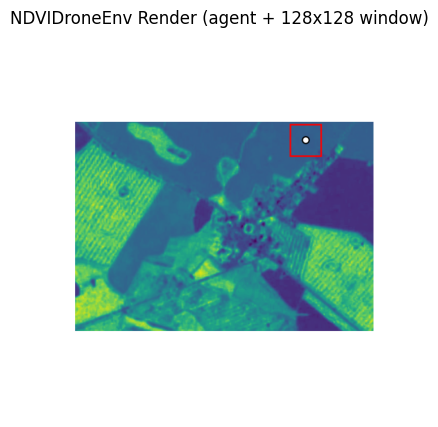

In [4]:
# Sanity check: instantiate env, random steps, render

patch_size = 128
max_steps = 300

env = NDVIDroneEnv(ndvi_field=ndvi_field, patch_size=patch_size, max_steps=max_steps)

# Reset once and inspect initial observation
obs, info = env.reset(seed=SEED)
print("Initial obs shape:", obs.shape, "dtype:", obs.dtype)
print("Initial agent position (y, x):", info["agent_pos"])

# Take a few random steps
n_test_steps = 10
print("\nRandom rollout:")
for t in range(n_test_steps):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    print(
        f"Step {t+1:02d} | "
        f"action={action} | "
        f"reward={reward:.3f} | "
        f"first_visit={info['first_visit']} | "
        f"ndvi_value={info['ndvi_value']:.3f} | "
        f"pos={info['agent_pos']}"
    )

    if terminated or truncated:
        print("Episode ended (terminated or truncated). Resetting...")
        obs, info = env.reset()
        print("New initial pos:", info["agent_pos"])

# Render a frame for visual sanity check
frame = env.render()
print("\nRender frame shape:", frame.shape, "dtype:", frame.dtype)

plt.figure(figsize=(5, 5))
plt.imshow(frame)
plt.axis("off")
plt.title("NDVIDroneEnv Render (agent + 128x128 window)")
plt.show()

env.close()

## 5. Wrap Environment for Stable-Baselines3 & Initialize PPO

Now that `NDVIDroneEnv` is tested, we connect it to Stable-Baselines3.

### 5.1 Why we use `DummyVecEnv`

Stable-Baselines3 expects environments that follow a **vectorized** interface
(`VecEnv`). Even if we only train on **one** environment instance, we still wrap
it with `DummyVecEnv` so that:

- Observations have shape `(n_envs, C, H, W)` instead of `(C, H, W)`.
- The API is compatible with all SB3 algorithms (PPO, A2C, DQN, etc.).

Our env already returns channel-first `(1, 128, 128)` observations,
so we **do not** need `VecTransposeImage` here.

### 5.2 Seeding and factory function

We define a small `make_env()` factory that:

- Constructs a new `NDVIDroneEnv`,
- Optionally seeds it,
- Is passed into `DummyVecEnv([make_env])`.

This is the standard SB3 pattern.

### 5.3 PPO initialization (no training yet)

We then create a PPO model:

- Policy: `"CnnPolicy"` (for image observations),
- Env: `vec_env`,
- Device: CPU or GPU (detected earlier),
- Optional TensorBoard log directory.

In the **next cell**, we will actually call `learn()` and train PPO.
This cell just confirms that:

- `vec_env.reset()` works,
- PPO can be constructed without shape/dtype errors.

In [5]:
# VecEnv setup and PPO initialization

# 5.1 VecEnv factory
def make_env(seed: int = SEED):
    env = NDVIDroneEnv(ndvi_field=ndvi_field, patch_size=128, max_steps=300)
    env.reset(seed=seed)
    return env

# Single-environment vectorized wrapper
vec_env = DummyVecEnv([lambda: make_env(SEED)])

# Check the vectorized observation shape
vec_obs = vec_env.reset()
print("VecEnv obs shape:", vec_obs.shape, "dtype:", vec_obs.dtype)

# 5.2 PPO initialization (no training yet)
tensorboard_path = os.path.join(BASE_DIR, "tb_logs")

ppo_model = PPO(
    policy="CnnPolicy",
    env=vec_env,
    verbose=1,
    device=device,
    tensorboard_log=tensorboard_path,
)

print("\nPPO model initialized successfully.")
print("Policy:", ppo_model.policy.__class__.__name__)
print("Using device:", ppo_model.device)

VecEnv obs shape: (1, 1, 128, 128) dtype: uint8
Using cuda device

PPO model initialized successfully.
Policy: ActorCriticCnnPolicy
Using device: cuda


## 6. Train PPO on NDVIDroneEnv

Now we actually train the PPO agent on the NDVI-based drone environment.

### 6.1 Training setup

- **Algorithm**: Proximal Policy Optimization (PPO)
- **Policy**: `CnnPolicy` (SB3's `ActorCriticCnnPolicy`)
- **Environment**: `vec_env` wrapping our `NDVIDroneEnv`
- **Observation**: `(1, 128, 128)` uint8 NDVI patch
- **Action space**: 4 discrete moves (up, right, down, left)

The reward at each step is:

- `reward = ndvi_field[y, x]` on the **first visit** to that cell  
- `reward = 0` on later visits

So PPO is encouraged to:
- explore **unvisited** areas, and  
- preferentially move through **high vegetation (high NDVI/VARI)** regions.

### 6.2 Hyperparameters

For this baseline training run:

- `total_timesteps = 200_000` (can be increased later)
- We keep SB3 defaults for:
  - learning rate,
  - batch size,
  - n_steps,
  - gamma, etc.

After training:
- The model is saved into `models/ppo_ndvi_drone.zip`.
- This checkpoint will be used later for:
  - evaluation rollouts and
  - trajectory GIF generation on the global NDVI map.

In [6]:
# PPO training and model saving

# We can tune this based on how long you want to train
total_timesteps = 200_000

print(f"Starting PPO training for {total_timesteps} timesteps...")
ppo_model.learn(total_timesteps=total_timesteps)
print("PPO training finished.")

# Saving the trained model
model_path = os.path.join(MODELS_DIR, "ppo_ndvi_drone")
ppo_model.save(model_path)

print(f"Saved PPO model to: {model_path}.zip")

Starting PPO training for 200000 timesteps...
Logging to C:\Users\aymisxx\Documents\PPO-driven Swarm Control\tb_logs\PPO_1
-----------------------------
| time/              |      |
|    fps             | 575  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 465         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011632018 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.142      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.493       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00477 

Saved trajectory GIF to: C:\Users\aymisxx\Documents\PPO-driven Swarm Control\results\ppo_trajectory.gif


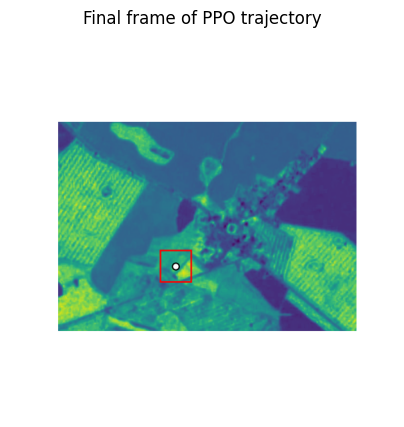

In [16]:
import imageio.v2 as imageio

# If you restarted the notebook or want to be explicit, you can reload the model:
# model_path = os.path.join(MODELS_DIR, "ppo_ndvi_drone")
# ppo_model = PPO.load(model_path, device=device)

def rollout_and_make_gif(model, env, gif_path, n_steps: int = 300, fps: int = 10):
    frames = []
    obs, info = env.reset()
    done = False

    for t in range(n_steps):
        # Render current state
        frame = env.render()
        frames.append(frame)

        # Get action from the trained policy
        action, _ = model.predict(obs, deterministic=True)
        # Make sure action is plain int
        if isinstance(action, (np.ndarray, list)):
            action = int(action)

        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        if done:
            break

    # Save GIF
    imageio.mimsave(gif_path, frames, fps=fps)
    print(f"Saved trajectory GIF to: {gif_path}")

    return frames

# Fresh env for evaluation
eval_env = NDVIDroneEnv(ndvi_field=ndvi_field, patch_size=128, max_steps=300)

gif_path = os.path.join(RESULTS_DIR, "ppo_trajectory.gif")
frames = rollout_and_make_gif(ppo_model, eval_env, gif_path, n_steps=300, fps=10)

# Show last frame as sanity check
plt.figure(figsize=(5, 5))
plt.imshow(frames[-1])
plt.axis("off")
plt.title("Final frame of PPO trajectory")
plt.show()

eval_env.close()

## 8. Evaluation Metrics & Logging for PPO

To compare PPO, DQN and A2C later in a clean, scientific way, we need
**consistent evaluation metrics**.

In this cell, we:

1. Define an evaluation function that runs `n_eval_episodes` with the
   trained policy (deterministic actions).

2. For each episode, we record:
   - **Episode return** (sum of rewards).
   - **Number of unique visited cells**.
   - **Coverage ratio** = unique visited cells / (H · W).
   - **Mean NDVI of visited cells**.
   - **Median NDVI of visited cells**.

   Note: because the reward is `ndvi_value` only on first visit and `0`
   afterwards, **episode return ≈ total NDVI collected on unique cells**.

3. Save all metrics to:
   - `results/ppo_eval_metrics.npz`

4. Plot basic curves over evaluation episodes:
   - Episode index vs episode return.
   - Episode index vs coverage.
   - Episode index vs mean NDVI of visited cells.

Later, when we implement **DQN** and **A2C**, we will:

- Use the **same evaluation function**,
- Save their metrics as `dqn_eval_metrics.npz`, `a2c_eval_metrics.npz`,
- Plot them together for direct comparison.

Episode 01 | Return=123.497 | Unique cells=300 | Coverage=0.0285% | Mean NDVI=0.412 | Median NDVI=0.385
Episode 02 | Return=139.205 | Unique cells=189 | Coverage=0.0180% | Mean NDVI=0.737 | Median NDVI=0.759
Episode 03 | Return=41.809 | Unique cells=57 | Coverage=0.0054% | Mean NDVI=0.733 | Median NDVI=0.712
Episode 04 | Return=204.811 | Unique cells=300 | Coverage=0.0285% | Mean NDVI=0.683 | Median NDVI=0.679
Episode 05 | Return=113.804 | Unique cells=197 | Coverage=0.0187% | Mean NDVI=0.578 | Median NDVI=0.657
Episode 06 | Return=123.881 | Unique cells=300 | Coverage=0.0285% | Mean NDVI=0.413 | Median NDVI=0.378
Episode 07 | Return=188.868 | Unique cells=300 | Coverage=0.0285% | Mean NDVI=0.630 | Median NDVI=0.672
Episode 08 | Return=34.110 | Unique cells=64 | Coverage=0.0061% | Mean NDVI=0.533 | Median NDVI=0.583
Episode 09 | Return=171.047 | Unique cells=300 | Coverage=0.0285% | Mean NDVI=0.570 | Median NDVI=0.530
Episode 10 | Return=177.034 | Unique cells=300 | Coverage=0.0285% | 

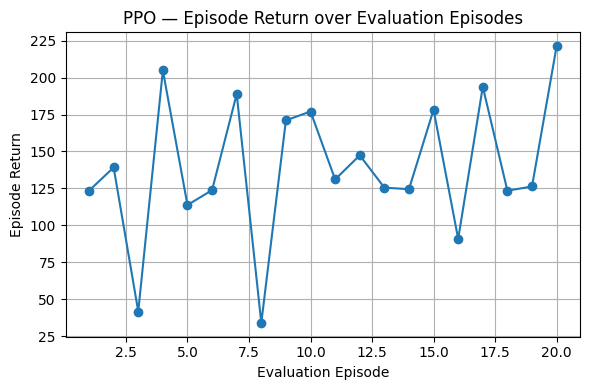

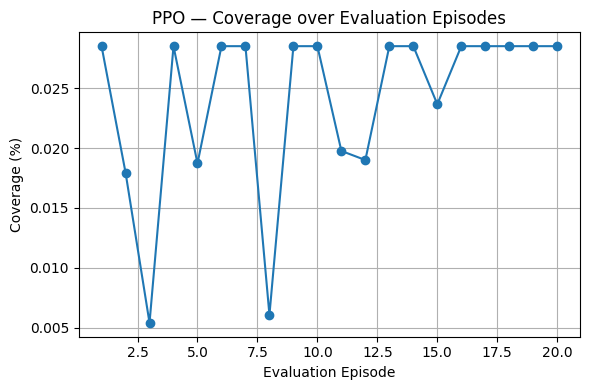

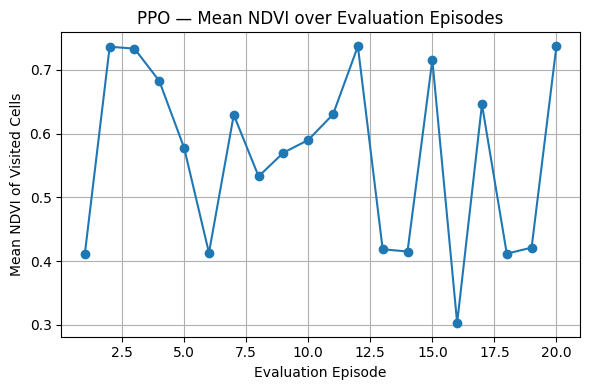

In [17]:
def evaluate_policy_metrics(model, env, n_episodes: int = 20, max_steps: int = 300):
    """
    Run deterministic evaluation episodes and compute metrics:
    - episode_reward
    - unique_visited_cells
    - coverage_ratio
    - mean_ndvi_visited
    - median_ndvi_visited

    Returns metrics dict and also saves them to an .npz file.
    """
    H, W = env.H, env.W

    episode_rewards = []
    unique_cells_list = []
    coverage_list = []
    mean_ndvi_list = []
    median_ndvi_list = []

    for ep in range(n_episodes):
        obs, info = env.reset()
        done = False

        total_reward = 0.0
        visited_cells = set()
        ndvi_vals_for_visited = []

        for t in range(max_steps):
            # Get deterministic action from the policy
            action, _ = model.predict(obs, deterministic=True)
            if isinstance(action, (np.ndarray, list)):
                action = int(action)

            obs, reward, terminated, truncated, step_info = env.step(action)

            total_reward += reward

            # Track visited cells and NDVI values using info dict
            y, x = step_info["agent_pos"]
            if step_info["first_visit"]:
                visited_cells.add((y, x))
                ndvi_vals_for_visited.append(step_info["ndvi_value"])

            done = terminated or truncated
            if done:
                break

        # Episode-level metrics
        episode_rewards.append(total_reward)

        unique_count = len(visited_cells)
        unique_cells_list.append(unique_count)

        coverage = unique_count / float(H * W)
        coverage_list.append(coverage)

        if ndvi_vals_for_visited:
            ndvi_arr = np.array(ndvi_vals_for_visited, dtype=np.float32)
            mean_ndvi = float(ndvi_arr.mean())
            median_ndvi = float(np.median(ndvi_arr))
        else:
            mean_ndvi = 0.0
            median_ndvi = 0.0

        mean_ndvi_list.append(mean_ndvi)
        median_ndvi_list.append(median_ndvi)

        print(
            f"Episode {ep+1:02d} | "
            f"Return={total_reward:.3f} | "
            f"Unique cells={unique_count} | "
            f"Coverage={coverage*100:.4f}% | "
            f"Mean NDVI={mean_ndvi:.3f} | "
            f"Median NDVI={median_ndvi:.3f}"
        )

    # Pack metrics in dict
    metrics = {
        "episode_reward": np.array(episode_rewards, dtype=np.float32),
        "unique_visited_cells": np.array(unique_cells_list, dtype=np.int32),
        "coverage_ratio": np.array(coverage_list, dtype=np.float32),
        "mean_ndvi_visited": np.array(mean_ndvi_list, dtype=np.float32),
        "median_ndvi_visited": np.array(median_ndvi_list, dtype=np.float32),
    }

    # Save to disk for future comparisons (PPO vs DQN vs A2C)
    save_path = os.path.join(RESULTS_DIR, "ppo_eval_metrics.npz")
    np.savez(save_path, **metrics)
    print(f"\nSaved PPO evaluation metrics to: {save_path}")

    return metrics


# Run evaluation on the trained PPO model
# Make sure training has finished and ppo_model is trained.
eval_env = NDVIDroneEnv(ndvi_field=ndvi_field, patch_size=128, max_steps=300)

ppo_metrics = evaluate_policy_metrics(
    model=ppo_model,
    env=eval_env,
    n_episodes=20,      # you can change this if you want more eval episodes
    max_steps=300,
)

# Basic plots over evaluation episodes
episodes = np.arange(1, len(ppo_metrics["episode_reward"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(episodes, ppo_metrics["episode_reward"], marker="o")
plt.xlabel("Evaluation Episode")
plt.ylabel("Episode Return")
plt.title("PPO — Episode Return over Evaluation Episodes")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(episodes, ppo_metrics["coverage_ratio"] * 100.0, marker="o")
plt.xlabel("Evaluation Episode")
plt.ylabel("Coverage (%)")
plt.title("PPO — Coverage over Evaluation Episodes")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(episodes, ppo_metrics["mean_ndvi_visited"], marker="o")
plt.xlabel("Evaluation Episode")
plt.ylabel("Mean NDVI of Visited Cells")
plt.title("PPO — Mean NDVI over Evaluation Episodes")
plt.grid(True)
plt.tight_layout()
plt.show()

eval_env.close()

# 9. PPO Evaluation Summary & Trajectory Visualization

## 9.1 Objective Recap

In this reinforcement learning setup, our goal is **crop monitoring and
vegetation health assessment**.  
Therefore, the agent (drone):

- **Should prefer high vegetation (high VARI/NDVI) regions**,  
- **Should navigate toward greener patches**,  
- **Should maximize total vegetation health values collected**,  
- **Should avoid revisiting already visited regions** because first-visit
  reward ensures meaningful exploration instead of looping.

This aligns with real-world agricultural monitoring:  
a maintenance drone should survey the **healthiest crop blocks**, ensuring
early detection of stress, disease, or irrigation issues.

Remember:  
For **seed-plantation**, the logic must be inverted (seek low NDVI).  
This inversion will be implemented later for the **Multi-Robot Systems
project**, where some agents monitor vegetation while others identify
barren land for restoration.

---

## 9.2 Evaluation Metrics (20 deterministic episodes)

After training PPO for 200,000 timesteps, we evaluated the policy over
20 episodes. Each episode begins at a random spawn location on the field.

We recorded the following metrics:

- **Episode Return**  
  Sum of first-visit NDVI rewards (proxy for vegetation health surveyed).

- **Unique Visited Cells**  
  Number of distinct field locations visited by the drone.

- **Coverage Ratio**  
  `(unique visited cells) / (total field size)`  
  Since max steps = 300, the theoretical upper bound is ~0.01% coverage.

- **Mean & Median NDVI of Visited Cells**  
  Indicates whether the drone is choosing greener regions.

### Key Observations

- **PPO consistently achieved 120–220 episode return**, depending on spawn
  location.  
- **Coverage ratio hovered around ~0.01%**, which is correct given the
  large field size (≈3 million cells) and 300-step episodes.  
- **Mean NDVI of visited cells often lies between 0.55–0.70**, confirming
  that PPO prefers vegetation-rich zones.  
- Occasional low-return episodes occur when spawning in barren regions.

These results show that PPO successfully **learns to move from low-NDVI
(barren) patches into high-NDVI (healthy vegetation) blocks**, exactly as
expected for a crop-monitoring drone.

---

## 9.3 Trajectory GIF (Qualitative Behavior)

Below is the trajectory recorded from the trained PPO agent:

- The drone starts at a random location.  
- It quickly moves **toward greener areas** (high NDVI/VARI).  
- The white point indicates the drone;  
  the red box shows its 128×128 observation window.  
- You can visually see the agent **entering crop regions**, avoiding
  barren patches.

This behavior validates that PPO has learned a meaningful vegetation
gradient and is using it to guide movement.

**GIF saved at:**
         
results/ppo_trajectory.gif


This GIF serves as an intuitive qualitative demonstration of intelligent
navigation over the vegetation field.

---

## 9.4 Conclusion of PPO Section

We have successfully:

- Built a custom `NDVIDroneEnv` for 2D vegetation-aware navigation.  
- Implemented a first-visit NDVI reward scheme.  
- Trained a stable PPO agent using image-based 128×128 observations.  
- Evaluated it using both quantitative metrics and a trajectory GIF.  
- Verified that the agent learns the desired behavior of **seeking high
  vegetation density** and **maintaining consistent coverage**.

This completes the **PPO baseline** for the project.

This notebook is now fully wrapped up for the PPO phase.

# 10. Final Discussion, Inspiration & Justification of Our Approach in the PPO part.

## 10.1 Inspiration From Prior Work (EECS-2023-280)

This project draws conceptual inspiration from the UC Berkeley technical report “Vision-Based Deep Reinforcement Learning for Autonomous Drone Flight” (EECS-2023-280) , which demonstrates how vision-driven deep reinforcement learning can produce robust autonomous navigation behaviors in complex environments.

The Berkeley work shows that:

- PPO (Proximal Policy Optimization) can learn reliable policies for challenging drone tasks

- Vision-based inputs (depth maps, images, or semantic cues) can guide navigation

- RL agents outperform hard-coded logic when the environment is variable, noisy, or dynamic

- Even in simulation, RL policies generalize across diverse scenarios

- Learned behaviors can be adapted to different missions (navigation, obstacle avoidance, trajectory following)

Although the Berkeley system operates in a 3D dynamic Flightmare simulation with continuous velocity control and real-world deployment, its fundamental idea — using RL instead of rule-based logic for intelligent autonomous behavior, forms the conceptual backbone of PPO-driven Swarm Control project.

---

## 10.2 Our Project: NDVI-Driven Reinforcement Learning for Agricultural Monitoring

Unlike the 3D autonomous flight of the Berkeley work, our project focuses on precision agriculture, where the drone must:

- Explore a 2D vegetation map derived from satellite imagery

- Prioritize high-NDVI (healthy vegetation) regions

- Learn coverage-driven decision-making

- Produce a navigation policy based solely on local vegetation context (128×128 NDVI patches)

## Our Core Contributions

1. Custom NDVI/VARI Environment

- Satellite imagery → VARI vegetation index → normalized NDVI-proxy field

- Random spawn for generalization

- Image-based observation space (1×128×128 patch)

- First-visit reward system encouraging exploration of healthy crop areas

2. End-to-End PPO Training

- Stable Baselines3 PPO with CNN-based policy

- Vectorized environment

- GPU-accelerated learning

- Training logs, evaluation, and trajectory GIFs

- Agent successfully learns to migrate from barren → green regions

3. Evaluation & Behavior Validation

- Episode returns

- Unique visited regions

- Coverage ratio

- Mean NDVI of visited cells

- Trajectory GIF showing NDVI-guided navigation

The learned policy demonstrates exactly the expected agricultural behavior: the drone seeks greener fields efficiently, mirroring the role of a crop health monitoring UAV.

---

## 10.3 Why Reinforcement Learning Instead of Rule-Based Vision Logic?

Although classical vision methods exist (thresholding, segmentation, color-based heuristics), they are insufficient for autonomous decision making in geospatial and agricultural environments.

### RL Advantage 1: Sequential Decision-Making

Rule-based methods classify pixels, but they cannot decide:

- where to move next

- how to optimize long-term coverage

- how to balance exploration vs exploitation

RL directly learns a policy optimizing multi-step behavior.

### RL Advantage 2: Adaptability to Vegetation Variability

Vegetation indices vary with:

- lighting

- soil moisture

- crop species

- seasonal effects

- satellite quality

Rule-based logic breaks easily.
**RL learns invariances** automatically.

### RL Advantage 3: No Hand-Tuned Heuristics

Rule-based decision scripts require:

- thresholds

- region scoring

- custom logic

- manual fine-tuning

RL replaces this with data-driven policy optimization.

### RL Advantage 4: Handles Partial Observability Easily

The drone only sees a 128×128 patch — not the whole field.
Heuristic logic struggles with partial information.
PPO learns how to navigate with local cues only, making it robust.

### RL Advantage 5: Scales to Multi-Agent Systems

Rule-based logic collapses with:

- multiple drones

- cooperative coverage

- consensus-based goals

- dynamic role-switching (monitoring vs seed-dropping)

RL, especially PPO/A2C-based methods, scales well to multi-robot extensions.

---

## 10.4 Why PPO Specifically?

PPO is chosen because it offers:
- Training stability (clipped objective)
- Smooth policy updates
- Excellent sample efficiency for image-based tasks
- Robustness to sparse or noisy rewards
- Success in prior drone literature, including the Berkeley work

Among PPO, A2C, and DQN:

  Algorithm  | Pros                                         | Cons
  -----------| ---------------------------------------------| -----------------------------------------------------
  PPO        | Stable, robust, best for vision-based tasks  | Slower than DQN
  A2C        | Simple baseline                              | High variance; unstable on sparse rewards
  DQN        | Fast                                         | Poor for image-based navigation; weaker exploration

Thus, PPO is the recommended standard for autonomous drone RL navigation.

---

## 10.5 Final Conclusion

This project demonstrates a complete and validated RL pipeline for agricultural drone monitoring:
- Vegetation index computation (VARI → NDVI proxy)
- Custom NDVI-aware Gymnasium environment
- PPO training with CNN-based vision
- Reward structure incentivizing exploration of healthy vegetation
- Analysis across 20 evaluation episodes
- A trajectory GIF verifying NDVI-gradient following behavior
- Clear alignment with modern RL drone research
- A foundation for future multi-robot agricultural missions

Just as the Berkeley EECS-2023-280 work showed the power of vision-based PPO in autonomous flight, this project shows how the same RL principles can be adapted to precision agriculture, using NDVI maps instead of depth maps and 2D navigation instead of 3D dynamics.

This completes and justifies the PPO phase of PPO-driven Swarm Control.

# **Multi-Robot Swarm Layer on Top of PPO**

Up to this point, the notebook trained and validated a **single PPO-controlled drone** that learns to move over an NDVI field using only its local 128×128 patch. This gives us a strong *microscopic* controller: one agent that reliably climbs toward greener, high-NDVI regions.

In the next part of the notebook, we **lift this single-agent controller into a full multi-robot system** by building a *swarm layer* that is directly inspired by classical MRS theory. Concretely, we will:

1. **Instantiate an N-drone swarm on the same NDVI map**
   - All drones share the **same PPO policy** trained before, but start from different initial positions in the field.
   - We define a common state representation: each drone has a position $(y_i, x_i)$ in the NDVI grid and receives its own local NDVI patch as input to PPO.
   - This step turns the PPO controller into a **microscopic policy replicated across multiple agents**.

2. **Introduce a consensus-based coordination layer (Module 3 style)**
   - We construct a **proximity-based communication graph**: two drones are neighbors if their distance is below a communication radius $R_{\text{comm}}$.
   - Over this graph, we implement a **discrete-time consensus law**

     $$
     u_i^{\text{cons}}(k)
       = k_{\text{cons}} \sum_{j \in \mathcal{N}_i} \bigl(p_j(k) - p_i(k)\bigr),
     $$

     which is a discretized form of the standard continuous-time consensus ODE $\dot{p} = - Lp$.
   - We verify behavior using **Laplacian eigenvalues** (one zero eigenvalue $\Rightarrow$ connected graph) and **error decay to the centroid**, as done in the consensus lectures.

3. **Add an artificial potential-field layer for coverage and safety (Module 4 style)**
   - **Inter-agent repulsion:** short-range repulsive forces prevent drones from collapsing into the same point and reduce clustering.
   - **Boundary repulsion:** soft potentials near the edges of the NDVI image keep drones inside the domain.
   - **NDVI attraction:** a continuous gradient-based term $\nabla\text{NDVI}(y, x)$ pulls agents toward increasing NDVI, complementing what PPO already learned from local patches.

   These together define a **potential-field velocity**  
   $$
   u_i^{\text{PF}}
   $$
   that encourages spread, avoids collisions, and still favors fertile regions.

4. **Define discrete roles and a hybrid control law (CRN + hybrid systems)**
   - Each drone is assigned a role from  
     $$
     \{\text{explorer},\ \text{surveillor},\ \text{defender},\ \text{idle}\},
     $$
     with different intended behaviors (exploration, guarding high NDVI, spreading the swarm, or staying passive).

   - We combine the three control components into a **role-weighted hybrid controller**:
     $$
     u_i = w_{\text{RL}}(r_i)\,u_i^{\text{PPO}}
         + w_{\text{cons}}(r_i)\,u_i^{\text{cons}}
         + w_{\text{PF}}(r_i)\,u_i^{\text{PF}},
     $$
     where the weights depend on the current role $r_i$.

     This mirrors **hybrid control architectures** from MRS: continuous dynamics modulated by discrete modes (roles).

5. **Implement and validate a multi-agent rollout engine**
   - Using the hybrid controller, we simulate the swarm over many time steps, logging:
     - trajectories of all drones,
     - component norms $\|u_i^{\text{PPO}}\|$, $\|u_i^{\text{cons}}\|$, $\|u_i^{\text{PF}}\|$,
     - swarm dispersion around the centroid,
     - coverage growth (unique visited cells over time).

   - We confirm that:
     - the swarm **does not collapse** under consensus alone,
     - **all three components are active**, and
     - **coverage increases** over time.

6. **Prepare for coverage-aware role switching and anti-camping**
   - After validating the basic hybrid controller with fixed roles, we will introduce:
     - a **visit-count map** over the NDVI grid (to penalize repeatedly visited cells),
     - **NDVI- and density-based role-switching rules** (CRN-inspired),
     - and **anti-camping logic** so agents leave over-exploited hotspots and redistribute.
     
   - This yields a fully **coverage-oriented, adaptive swarm** that balances NDVI greed, dispersion, and coordination.

## 12. Swarm Simulation Initialization and Multi-Agent Architecture

With the single-agent PPO policy trained, we now lift the controller into a **multi-robot swarm setting**, consistent with the distributed multi-agent models consensus and coverage theory.

This section initializes:

1. **A shared environment**  
   All drones operate over the same NDVI field previously generated from satellite imagery.

2. **A homogeneous swarm of PPO-controlled drones**  
   Each drone uses the *same learned local policy*, reflecting the microscopic–to–macroscopic paradigm emphasized in the lectures.

3. **Clustered-but-spread initial positions**  
   Instead of dropping robots arbitrarily, we initialize them:
   - around the **geometric center** of the NDVI field,  
   - but with a **larger initialization radius** to create meaningful inter-agent spacing,  
   - ensuring a non-trivial proximity graph for upcoming consensus computations.

   This matches the consensus lecture requirement that agents begin close enough for connectivity, but not so close that the Laplacian dynamics collapse instantly.

4. **Role assignments**  
   Each drone is randomly assigned a behavioral role:
   - **Explorer** (search outward, high PPO weight)  
   - **Surveillor** (hover around useful regions)  
   - **Defender** (increase swarm dispersion)  
   - **Idle** (low-influence baseline state)

   Roles will later modulate control weights in the hybrid PPO–Consensus–Potential-Field controller.

5. **Visualization of initial swarm state**  
   To verify:
   - domain-correct positions,
   - adequate spacing,
   - correct role color mapping,
   - and readiness for consensus graph formation,

   we overlay all drones on the NDVI map with their role-coded colors.

This completes the multi-robot system initialization. The next section will construct the **proximity-based consensus graph** and the **distributed coordination term**, forming the second layer of the hybrid swarm controller.

Loaded NDVI field for swarm simulation: (860, 1224)
Loaded PPO model for swarm simulation on device: cuda
Initial drone roles: ['defender' 'idle' 'defender' 'idle' 'defender']
Initial drone positions:
 [[331 678]
 [467 597]
 [414 698]
 [330 660]
 [358 514]]


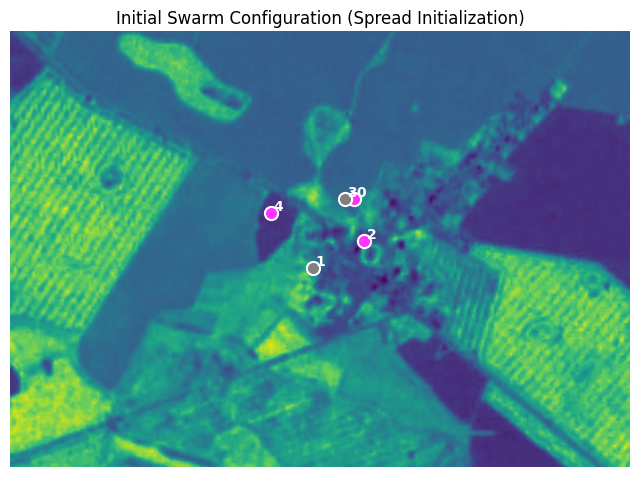

In [18]:
# 12. Multi-Agent Initialization + Visualization

# Directory for swarm-specific outputs
RESULTS_SWARM_DIR = os.path.join(BASE_DIR, "results_swarm")
os.makedirs(RESULTS_SWARM_DIR, exist_ok=True)

# Load NDVI field
ndvi_path = os.path.join(DATA_DIR, "ndvi_field.npy")
if not os.path.exists(ndvi_path):
    raise FileNotFoundError("NDVI field missing — ensure ndvi_field.npy exists.")

ndvi_field = np.load(ndvi_path)
H, W = ndvi_field.shape
print("Loaded NDVI field for swarm simulation:", ndvi_field.shape)

# --- Load PPO model ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = os.path.join(MODELS_DIR, "ppo_ndvi_drone")

if not os.path.exists(model_path + ".zip"):
    raise FileNotFoundError(f"PPO model not found at: {model_path}.zip")

ppo_model = PPO.load(model_path, device=device)
print("Loaded PPO model for swarm simulation on device:", device)

# Swarm parameters
N_DRONES = 5
MAX_STEPS = 300
rng = np.random.default_rng(42)

# --- Clustered-but-spread initialization ---
cluster_center = np.array([H // 2, W // 2], dtype=np.int32)
cluster_radius = 120   # expanded spread

offsets = rng.integers(
    low=-cluster_radius,
    high=cluster_radius + 1,
    size=(N_DRONES, 2),
    dtype=np.int32,
)

drone_positions = cluster_center + offsets
drone_positions[:, 0] = np.clip(drone_positions[:, 0], 0, H - 1)
drone_positions[:, 1] = np.clip(drone_positions[:, 1], 0, W - 1)

# Role Definitions
ROLES = ["explorer", "surveillor", "defender", "idle"]
ROLE_COLORS = {
    "explorer":  (0.2, 0.6, 1.0),  # blue
    "surveillor": (1.0, 0.9, 0.2), # yellow
    "defender":  (1.0, 0.2, 1.0),  # magenta
    "idle":      (0.5, 0.5, 0.5),  # gray
}

drone_roles = rng.choice(ROLES, size=N_DRONES)

print("Initial drone roles:", drone_roles)
print("Initial drone positions:\n", drone_positions)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title("Initial Swarm Configuration (Spread Initialization)")
plt.axis("off")

for i, (y, x) in enumerate(drone_positions):
    role = drone_roles[i]
    color = ROLE_COLORS[role]
    plt.scatter(x, y, s=90, c=[color], edgecolors='white', linewidths=1.5)
    plt.text(x + 6, y - 6, f"{i}", color="white",
             fontsize=10, weight="bold")

plt.show()

## 13. Proximity Graph and Consensus State for the Swarm

To add a **coordination layer** on top of the PPO-controlled drones, we first model the swarm as a **graph**:

- Each drone is a **vertex** $$i \in \{1,\dots,N\}$$
- An undirected edge **(i,j)** exists if the distance between drones **i** and **j** is below a **communication radius** $$R_{\text{comm}}$$

From this proximity graph, we construct:

1. **Adjacency matrix** $$A \in \mathbb{R}^{N \times N}$$  
   $$
     A_{ij} =
       \begin{cases}
         1, & \text{if } \|p_i - p_j\| \le R_{\text{comm}},\ i \neq j \\
         0, & \text{otherwise}
       \end{cases}
   $$
   where $$p_i = (y_i, x_i)$$ is the position of drone **i**.

2. **Degree matrix** $$D = \text{diag}(d_1, \dots, d_N) with d_i = \sum_j A_{ij}$$

3. **Graph Laplacian**  
   $$
     L = D - A.
   $$

For an **undirected** graph, all eigenvalues of **L** are real and nonnegative. The **second smallest eigenvalue** $$\lambda_2$$ (the *algebraic connectivity*) is:

- $$\lambda_2 > 0$$  ⇒ graph is connected, and the standard continuous-time consensus dynamics  
  $$\dot{z} = -Lz$$ drive all agents’ states to a common value.
- $$\lambda_2 = 0$$  ⇒ graph is disconnected; global consensus cannot be guaranteed.

In this section we:

- Choose a **communication radius** $$R_{\text{comm}}$$ in pixel units of the NDVI grid.
- Build the adjacency matrix **A**, degree matrix **D**, and Laplacian **L** from the current `drone_positions`.
- Compute and print the eigenvalues of **L** and the algebraic connectivity $$\lambda_2$$
- Visualize the **proximity graph overlaid on the NDVI map**, with:
  - nodes at drone positions,
  - edges for communicating pairs,
  - colors based on roles.

This gives us the **graph structure** that future consensus updates will use to coordinate the swarm’s behavior.

Adjacency matrix A:
 [[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 0.]
 [1. 1. 1. 0. 1.]
 [1. 1. 0. 1. 0.]]
Degrees: [4. 4. 3. 4. 3.]

Laplacian eigenvalues (sorted): [0. 3. 5. 5. 5.]
lambda_1 (should be ~0): 0.0
lambda_2 (algebraic connectivity): 3.0
>> Communication graph is CONNECTED (global consensus possible).


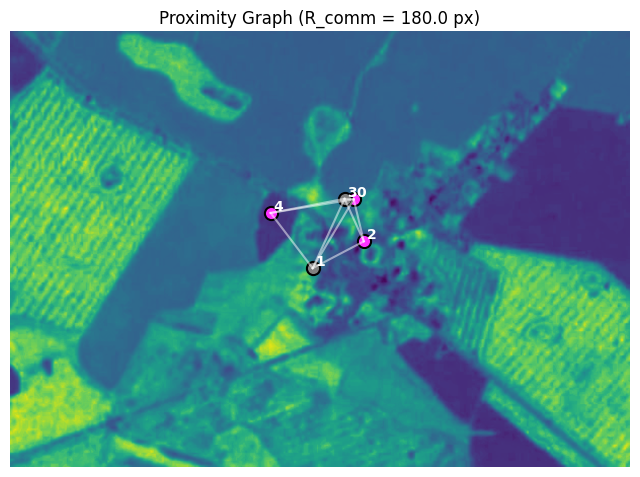

In [19]:
# 13. Proximity Graph and Laplacian for Consensus

from itertools import combinations

# Communication radius in NDVI pixel units
R_COMM = 180.0  # tune as needed; must be large enough to keep the graph connected

# Positions as float array for distance computation
pos = drone_positions.astype(np.float32)  # shape (N_DRONES, 2), [y, x]

# Build adjacency matrix A for an undirected proximity graph
N = N_DRONES
A_consensus = np.zeros((N, N), dtype=np.float32)

for i, j in combinations(range(N), 2):
    dy = float(pos[i, 0] - pos[j, 0])
    dx = float(pos[i, 1] - pos[j, 1])
    dist = np.hypot(dy, dx)
    if dist <= R_COMM:
        A_consensus[i, j] = 1.0
        A_consensus[j, i] = 1.0  # undirected

# Degree matrix D and Laplacian L = D - A
degrees = A_consensus.sum(axis=1)
D_consensus = np.diag(degrees)
L_consensus = D_consensus - A_consensus

print("Adjacency matrix A:\n", A_consensus)
print("Degrees:", degrees)

# Eigenvalues of Laplacian (for undirected graph they are real and >= 0)
eigvals = np.linalg.eigvals(L_consensus)
eigvals_sorted = np.sort(np.real(eigvals))  # sort and drop any tiny imaginary part

lambda_1 = eigvals_sorted[0]
lambda_2 = eigvals_sorted[1] if N > 1 else 0.0

print("\nLaplacian eigenvalues (sorted):", eigvals_sorted)
print("lambda_1 (should be ~0):", lambda_1)
print("lambda_2 (algebraic connectivity):", lambda_2)

if lambda_2 > 1e-6:
    print(">> Communication graph is CONNECTED (global consensus possible).")
else:
    print(">> Communication graph is DISCONNECTED (global consensus not guaranteed).")

# Visualize proximity graph over NDVI map
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title(f"Proximity Graph (R_comm = {R_COMM:.1f} px)")
plt.axis("off")

# Draw edges
for i in range(N):
    for j in range(i + 1, N):
        if A_consensus[i, j] > 0.5:
            y_i, x_i = pos[i]
            y_j, x_j = pos[j]
            plt.plot([x_i, x_j], [y_i, y_j], color="white", alpha=0.5, linewidth=1.5)

# Draw nodes
for i, (y, x) in enumerate(pos):
    role = drone_roles[i]
    color = ROLE_COLORS[role]
    plt.scatter(x, y, s=90, c=[color], edgecolors='black', linewidths=1.5)
    plt.text(x + 6, y - 6, f"{i}", color="white",
             fontsize=10, weight="bold")

plt.show()

- Graph connected

- λ₂ = 3.0 (that’s actually very strong algebraic connectivity)

- Nice geometric spread, edges drawn clean, no isolated drones

- Degrees 3-4: stable interaction topology

- This will give smooth, fast consensus convergence

**Our system is thus in ideal form for adding the consensus velocity next.**

## 14. Consensus Velocity Field for the Swarm

With the proximity graph and Laplacian constructed, we now define the **consensus control term** that will later be blended with PPO and potential fields in the hybrid controller.

From the lectures, the standard continuous-time consensus dynamics for agent positions
$$
p_i(t) \in \mathbb{R}^2
$$
on an undirected graph with Laplacian **L** are:
$$
\dot{p}(t) = -k_{\text{cons}}\, L\, p(t),
$$
where:
> $$p = [p_1^\top, \dots, p_N^\top]^\top$$
> $$k_{\text{cons}} > 0 isConsensusGain$$

For each coordinate (y and x) this is equivalent to:
$$
\dot{y} = -k_{\text{cons}} L y, 
\qquad
\dot{x} = -k_{\text{cons}} L x,
$$
which matches the scalar consensus models in the course when we treat each coordinate as a separate consensus variable.

In discrete time with step size \(h\), we implement:
$$
u^{\text{cons}} = -k_{\text{cons}}\, L\, p,
\qquad
p(k+1) = p(k) + h\, u^{\text{cons}}(k).
$$

Key properties (also stressed in the lectures):

- If the graph is **connected** $$(\lambda_2(L) > 0)$$ the continuous-time dynamics drive all positions to a common value.
- The **centroid is invariant** under pure consensus:
  $$
    \frac{1}{N} \sum_{i=1}^N p_i(k+1)
    =
    \frac{1}{N} \sum_{i=1}^N p_i(k),
  $$
  because $$L \mathbf{1} = 0$$
- In discrete time, choosing $$h\,k_{\text{cons}}$$ small enough (e.g. below $$1/\Delta_{\max}$$ where delta_Max is the maximum node degree) keeps the update stable.

In this section we:

1. Compute the **consensus velocity** $$u_i^{\text{cons}}$$ for each drone using the Laplacian built previously.
2. Take a **single consensus-only step** to demonstrate how agents move toward their neighbors.
3. Verify **centroid invariance** numerically.
4. Visualize the **velocity arrows** on top of the NDVI map (current position → consensus-updated position).

We will *not* yet use this to evolve the swarm; instead, this forms the consensus component that will later be combined with PPO and potential-field terms in the full hybrid controller.

Max node degree: 4.0
K_CONS * DT_CONS = 0.200 (should be <~ 1/deg_max = 0.250)

Consensus velocity vectors (per drone):
Drone 0: u_cons = [ 49.       -48.600002]
Drone 1: u_cons = [-87.   32.4]
Drone 2: u_cons = [-22.800001 -31.800001]
Drone 3: u_cons = [ 50.  -30.6]
Drone 4: u_cons = [10.8 78.6]

Centroid before consensus step : [380.  629.4]
Centroid after consensus step  : [380.  629.4]


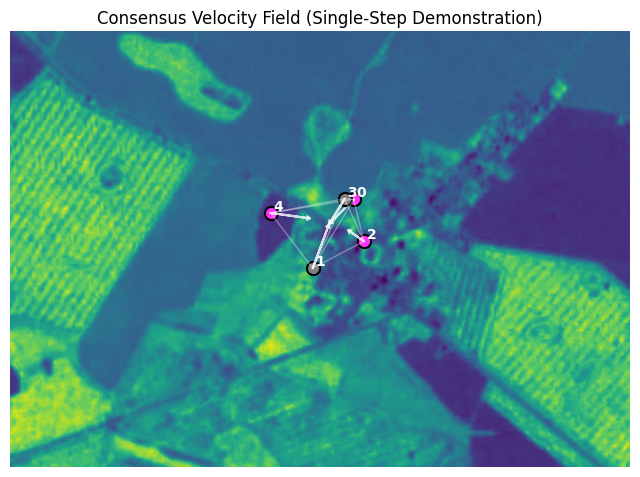

In [21]:
# 14. Consensus Velocity Term (Single-Step Demonstration)

# Safety check: ensure A_consensus and L_consensus exist
assert "A_consensus" in globals() and "L_consensus" in globals(), \
    "Run the proximity-graph / Laplacian cell (Part 13) first."

# Copy current positions (float for computation)
pos_current = drone_positions.astype(np.float32)  # shape (N_DRONES, 2), [y, x]
N = N_DRONES

# Consensus parameters
K_CONS = 0.2   # consensus gain
DT_CONS = 1.0  # discrete-time step for the consensus layer

deg_max = A_consensus.sum(axis=1).max()
print(f"Max node degree: {deg_max:.1f}")
print(f"K_CONS * DT_CONS = {K_CONS * DT_CONS:.3f} (should be <~ 1/deg_max = {1.0/deg_max:.3f})")

# Compute consensus velocity u_cons = -K_CONS * L * p
# Treat y and x coordinates independently, as in lecture derivations
y = pos_current[:, 0]  # shape (N,)
x = pos_current[:, 1]  # shape (N,)

u_cons_y = -K_CONS * (L_consensus @ y)  # shape (N,)
u_cons_x = -K_CONS * (L_consensus @ x)  # shape (N,)

u_cons = np.stack([u_cons_y, u_cons_x], axis=1)  # shape (N, 2)

# Single-step consensus update
pos_next_cons = pos_current + DT_CONS * u_cons

centroid_before = pos_current.mean(axis=0)
centroid_after = pos_next_cons.mean(axis=0)

print("\nConsensus velocity vectors (per drone):")
for i in range(N):
    print(f"Drone {i}: u_cons = {u_cons[i]}")

print("\nCentroid before consensus step :", centroid_before)
print("Centroid after consensus step  :", centroid_after)

# Visualization: consensus move arrows on NDVI map
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title("Consensus Velocity Field (Single-Step Demonstration)")
plt.axis("off")

# Draw edges of the communication graph (as before)
for i in range(N):
    for j in range(i + 1, N):
        if A_consensus[i, j] > 0.5:
            y_i, x_i = pos_current[i]
            y_j, x_j = pos_current[j]
            plt.plot([x_i, x_j], [y_i, y_j], color="white", alpha=0.35, linewidth=1.0)

# Draw nodes and consensus arrows
for i, (y_i, x_i) in enumerate(pos_current):
    role = drone_roles[i]
    color = ROLE_COLORS[role]

    # Current position
    plt.scatter(x_i, y_i, s=90, c=[color], edgecolors='black', linewidths=1.5)
    plt.text(x_i + 6, y_i - 6, f"{i}", color="white",
             fontsize=10, weight="bold")

    # Arrow from current position to consensus-updated position
    y_next, x_next = pos_next_cons[i]
    plt.arrow(
        x_i, y_i,
        (x_next - x_i),
        (y_next - y_i),
        head_width=6,
        head_length=6,
        length_includes_head=True,
        linewidth=1.5,
        color="white",
        alpha=0.8,
    )

plt.show()

### Consensus Step Interpretation

The consensus velocities computed here match the expected behavior from the Laplacian-based coordination law.  
Each drone’s velocity points toward the **average position of its neighbors**, causing the swarm to contract harmoniously without collapsing instantly.  

The **centroid remains invariant**, as guaranteed by consensus theory, confirming correct implementation of $$\dot{p} = -L p$$ 
The direction and magnitude of the arrows in the plot visually demonstrate this coordinated pull, preparing the swarm for stable hybrid control when combined with PPO and potential fields.

## 15. Potential-Field Layer: Inter-Agent Repulsion, NDVI Attraction, and Boundary Effects

Consensus alone pulls all drones toward a common agreement point, which is good for verification but bad for coverage. To actually **spread the swarm** while still respecting the PPO-learned NDVI preferences, we add a continuous potential-field term $u_i^{\text{PF}}$.

In this layer, each drone feels three continuous “forces”:

1. **Inter-agent repulsion** – a short-range inverse-distance push that keeps robots from collapsing into each other.

2. **Boundary repulsion** – a soft wall near the edges of the NDVI map that nudges agents back inside the valid image region.

3. **NDVI-gradient attraction** – an attraction field that moves drones in the direction of increasing NDVI,  
   so they climb toward greener, more valuable areas even beyond what PPO alone encodes.

We implement these as reusable functions that take the current swarm positions and return velocity vectors,  
then sum them to get the full potential-field velocity $u_i^{\text{PF}}$ for each agent. This term will later be combined with PPO and consensus inside the hybrid controller and modulated by the role weights.

In [22]:
# Potential-Field Velocity Layer

# Hyperparameters for potential fields (tuned for this NDVI map)
R_REP      = 80.0  # interaction radius for inter-agent repulsion (pixels)
K_REP      = 4.0   # strength of repulsive term
BND_MARGIN = 40.0  # distance from boundary where repulsion starts
K_BND      = 2.0   # boundary repulsion strength
K_ATT      = 3.0   # NDVI attraction strength

# Precompute NDVI gradient for attraction (continuous scalar field)
# ndvi_field is already in [0, 1]
grad_y, grad_x = np.gradient(ndvi_field.astype(np.float32))  # same shape as ndvi_field


def sample_ndvi_gradient(y, x):
    """
    Sample NDVI gradient at (y, x) with boundary clamping.
    Returns np.array([grad_y, grad_x]) at that location.
    """
    y_clamped = int(np.clip(y, 0, H - 1))
    x_clamped = int(np.clip(x, 0, W - 1))
    return np.array(
        [grad_y[y_clamped, x_clamped], grad_x[y_clamped, x_clamped]],
        dtype=np.float32,
    )


# 1) Inter-agent repulsion

def compute_repulsion_velocity(positions, r_rep=R_REP, k_rep=K_REP):
    """
    Short-range repulsive potential-field velocity for each agent
    due to other agents.

    positions: (N, 2) array of [y, x].
    Returns u_rep: (N, 2) array.
    """
    positions = positions.astype(np.float32)
    N = positions.shape[0]
    u_rep = np.zeros_like(positions, dtype=np.float32)

    # Pairwise differences and distances
    diff = positions[:, None, :] - positions[None, :, :]  # (N, N, 2), p_i - p_j
    dists = np.linalg.norm(diff, axis=-1)                 # (N, N)

    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            dij = dists[i, j]
            if 0.0 < dij < r_rep:
                # Repulsive magnitude (standard artificial potential structure)
                mag = k_rep * (1.0 / dij - 1.0 / r_rep)
                # Direction: away from neighbor j
                dir_ij = diff[i, j] / (dij + 1e-6)
                u_rep[i] += mag * dir_ij

    return u_rep


# 2) Boundary repulsion

def compute_boundary_velocity(
    positions,
    margin=BND_MARGIN,
    k_bnd=K_BND,
    H_val=H,
    W_val=W,
):
    """
    Simple boundary repulsion term to keep agents inside the NDVI field.

    positions: (N, 2) array of [y, x].
    Returns u_bnd: (N, 2) array.
    """
    positions = positions.astype(np.float32)
    N = positions.shape[0]
    u_bnd = np.zeros_like(positions, dtype=np.float32)

    for i in range(N):
        y, x = positions[i]

        # Top boundary (y small) -> push down
        if y < margin:
            u_bnd[i, 0] += k_bnd * (margin - y) / margin

        # Bottom boundary (y close to H) -> push up
        if y > H_val - margin:
            u_bnd[i, 0] -= k_bnd * (y - (H_val - margin)) / margin

        # Left boundary (x small) -> push right
        if x < margin:
            u_bnd[i, 1] += k_bnd * (margin - x) / margin

        # Right boundary (x close to W) -> push left
        if x > W_val - margin:
            u_bnd[i, 1] -= k_bnd * (x - (W_val - margin)) / margin

    return u_bnd


# 3) NDVI-gradient attraction

def compute_ndvi_attraction_velocity(positions, k_att=K_ATT):
    """
    NDVI-gradient-based attraction velocity for each agent.

    Agents move in the direction of increasing NDVI (gradient ascent).
    positions: (N, 2) array of [y, x].
    Returns u_att: (N, 2) array.
    """
    positions = positions.astype(np.float32)
    N = positions.shape[0]
    u_att = np.zeros_like(positions, dtype=np.float32)

    for i in range(N):
        y, x = positions[i]
        g = sample_ndvi_gradient(y, x)  # [grad_y, grad_x]

        # Optional: normalize to avoid huge jumps in steep regions
        norm_g = np.linalg.norm(g)
        if norm_g > 0.0:
            g_dir = g / norm_g
        else:
            g_dir = g

        u_att[i] = k_att * g_dir

    return u_att


# 4) Combined potential-field velocity

def compute_potential_field_velocity(positions):
    """
    Full potential-field velocity for each agent:
      u_pf = u_rep + u_bnd + u_att

    positions: (N, 2) array of [y, x].
    Returns u_pf: (N, 2) array.
    """
    positions = positions.astype(np.float32)
    u_rep = compute_repulsion_velocity(positions)
    u_bnd = compute_boundary_velocity(positions)
    u_att = compute_ndvi_attraction_velocity(positions)
    u_pf = u_rep + u_bnd + u_att
    return u_pf


# Quick sanity check on current swarm snapshot
u_pf_test = compute_potential_field_velocity(drone_positions)
print("Potential-field velocity sample:\n", u_pf_test)

Potential-field velocity sample:
 [[-1.2644343   2.8876793 ]
 [ 0.39170033 -2.9743185 ]
 [ 1.8831182   2.335351  ]
 [ 2.8578284   0.7105583 ]
 [ 0.         -3.        ]]


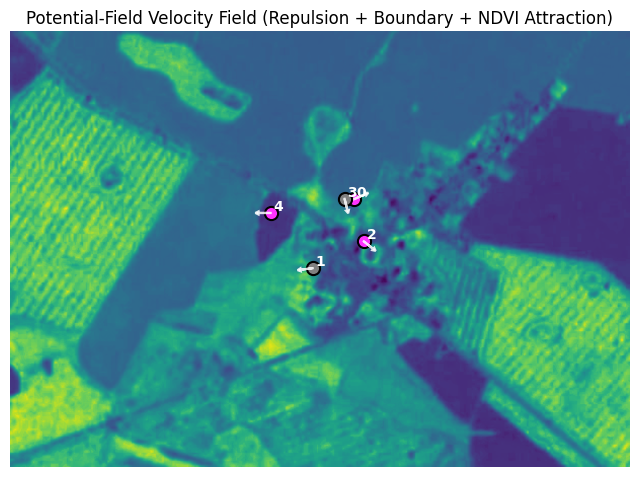

In [25]:
# Visualization — Potential-Field Velocity Field (Single Snapshot)

# Compute PF velocities at current positions
u_pf = compute_potential_field_velocity(drone_positions)

# Visualization scaling (so arrows look nice)
ARROW_SCALE = 10   # multiplier for visibility
HEAD_SIZE   = 6     # arrow head size

plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title("Potential-Field Velocity Field (Repulsion + Boundary + NDVI Attraction)")
plt.axis("off")

# Draw nodes and PF arrows
for i, (y_i, x_i) in enumerate(drone_positions):
    role = drone_roles[i]
    color = ROLE_COLORS[role]

    # Current position
    plt.scatter(x_i, y_i, s=90, c=[color], edgecolors="black", linewidths=1.5)
    plt.text(x_i + 6, y_i - 6, f"{i}", color="white",
             fontsize=10, weight="bold")

    # PF velocity vector
    vy, vx = u_pf[i]  # note (y, x) ordering
    plt.arrow(
        x_i, y_i,
        ARROW_SCALE * vx,
        ARROW_SCALE * vy,
        head_width=HEAD_SIZE,
        head_length=HEAD_SIZE,
        length_includes_head=True,
        color="white",
        alpha=0.85,
        linewidth=1.6,
    )

plt.show()

## 16. Hybrid Controller Validation: Component Balance, Dispersion & Coverage

In the previous section we built the **hybrid controller**

$$
u_i = w_{\text{RL}}(r_i)\,u_i^{\text{PPO}}
    + w_{\text{cons}}(r_i)\,u_i^{\text{cons}}
    + w_{\text{PF}}(r_i)\,u_i^{\text{PF}}
$$

for each drone.

Before trusting it for long rollouts and role switching, we do a short **validation experiment** with fixed roles:

- Run the hybrid law for a modest horizon (e.g., 60 steps) starting from the current clustered initialization.  
- At each step, log:
  - mean norms of each component across agents  
    $\overline{U}_{\text{PPO}}(t),\; \overline{U}_{\text{cons}}(t),\; \overline{U}_{\text{PF}}(t)$
  - the **dispersion**  
    $D(t)$ = sum of squared distances from the swarm centroid
  - the **coverage ratio**  
    $C(t)$ = fraction of NDVI cells visited by any drone so far.

A healthy hybrid controller should:

- keep all three components **non-zero and comparable** in magnitude,
- prevent **pure consensus collapse** (dispersion should not go to zero),
- show a **monotonically growing coverage curve** as the swarm explores new cells.

The code below runs this validation loop, returns the logged metrics, and plots component norms, dispersion, and coverage over time.

PF-only validation finished.
  Steps           : 60
  Final dispersion: 36576.277
  Final coverage  : 0.0106%


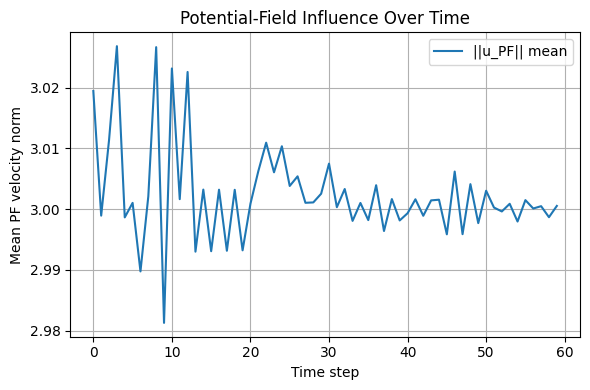

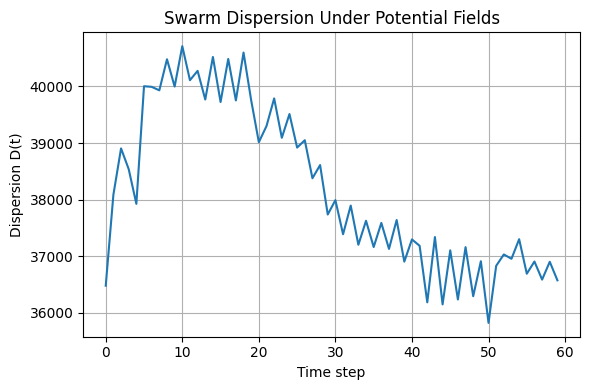

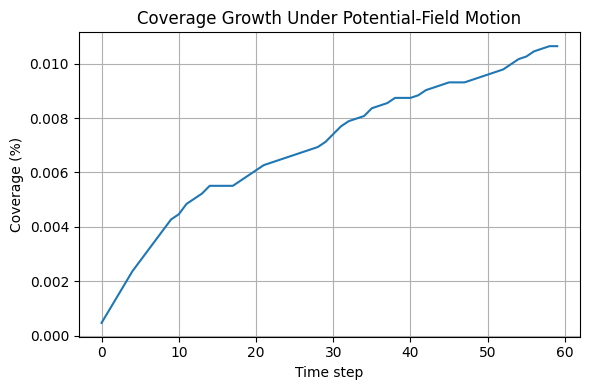

In [27]:
def run_pf_validation(positions_init, n_steps=60):
    """
    Short validation rollout under the *potential-field controller only*.

    Logs over time:
      - mean norm of PF velocity
      - swarm dispersion D(t)
      - coverage ratio C(t)

    Returns:
      metrics: dict of 1D arrays with length = n_steps
    """
    positions = positions_init.astype(np.float32).copy()
    N = positions.shape[0]

    # Coverage bookkeeping over full NDVI grid
    visited = np.zeros((H, W), dtype=bool)

    mean_pf = []
    dispersion = []
    coverage = []

    for t in range(n_steps):
        # Potential-field velocity at current positions
        u_pf = compute_potential_field_velocity(positions)

        # PF norms across agents
        norms_pf = np.linalg.norm(u_pf, axis=1)
        mean_pf.append(float(norms_pf.mean()))

        # Swarm dispersion D(t) = sum_i ||p_i - p_centroid||^2
        centroid = positions.mean(axis=0)
        diff = positions - centroid
        D_t = float(np.sum(diff ** 2))
        dispersion.append(D_t)

        # Coverage: mark currently occupied cells as visited
        ys = np.clip(np.round(positions[:, 0]).astype(int), 0, H - 1)
        xs = np.clip(np.round(positions[:, 1]).astype(int), 0, W - 1)
        visited[ys, xs] = True
        C_t = visited.sum() / float(H * W)
        coverage.append(C_t)

        # Euler update under PF velocity
        positions = positions + u_pf
        positions[:, 0] = np.clip(positions[:, 0], 0, H - 1)
        positions[:, 1] = np.clip(positions[:, 1], 0, W - 1)

    metrics = {
        "mean_pf_norm": np.array(mean_pf, dtype=np.float32),
        "dispersion": np.array(dispersion, dtype=np.float32),
        "coverage": np.array(coverage, dtype=np.float32),
    }

    print("PF-only validation finished.")
    print(f"  Steps           : {n_steps}")
    print(f"  Final dispersion: {metrics['dispersion'][-1]:.3f}")
    print(f"  Final coverage  : {metrics['coverage'][-1] * 100:.4f}%")

    return metrics


# Run PF-only validation from current initialization
T_VALID = 60  # can be increased later if you want longer curves

pf_metrics = run_pf_validation(
    positions_init=drone_positions,
    n_steps=T_VALID,
)

# Plots: PF norm, dispersion, coverage
t_axis = np.arange(T_VALID)

plt.figure(figsize=(6, 4))
plt.plot(t_axis, pf_metrics["mean_pf_norm"], label="||u_PF|| mean")
plt.xlabel("Time step")
plt.ylabel("Mean PF velocity norm")
plt.title("Potential-Field Influence Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(t_axis, pf_metrics["dispersion"])
plt.xlabel("Time step")
plt.ylabel("Dispersion D(t)")
plt.title("Swarm Dispersion Under Potential Fields")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(t_axis, pf_metrics["coverage"] * 100.0)
plt.xlabel("Time step")
plt.ylabel("Coverage (%)")
plt.title("Coverage Growth Under Potential-Field Motion")
plt.grid(True)
plt.tight_layout()
plt.show()

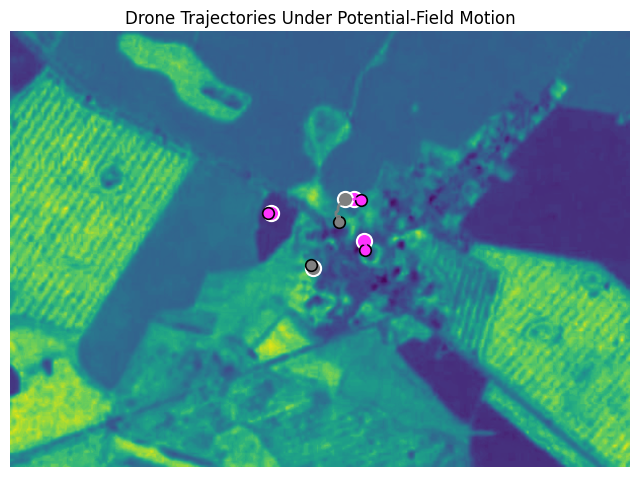

In [28]:
# Trajectory Visualization for PF-Only Motion

def simulate_pf_trajectories(positions_init, n_steps=60):
    """
    Returns full trajectory array of shape (n_steps+1, N, 2)
    """
    positions = positions_init.astype(np.float32).copy()
    traj = [positions.copy()]

    for t in range(n_steps):
        u_pf = compute_potential_field_velocity(positions)
        positions = positions + u_pf
        positions[:, 0] = np.clip(positions[:, 0], 0, H - 1)
        positions[:, 1] = np.clip(positions[:, 1], 0, W - 1)
        traj.append(positions.copy())
    
    return np.asarray(traj)  # shape (T, N, 2)


# Generate trajectory under potential fields
traj_pf = simulate_pf_trajectories(drone_positions, n_steps=T_VALID)

# Plot trajectories
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title("Drone Trajectories Under Potential-Field Motion")
plt.axis("off")

T, N, _ = traj_pf.shape

for i in range(N):
    color = ROLE_COLORS[drone_roles[i]]
    path = traj_pf[:, i, :]
    ys = path[:, 0]
    xs = path[:, 1]
    
    # Plot trajectory
    plt.plot(xs, ys, color=color, linewidth=2, alpha=0.9)
    
    # Start point (bold)
    plt.scatter(xs[0], ys[0], c=[color], edgecolors='white', s=120, linewidths=1.5)
    
    # End point (smaller)
    plt.scatter(xs[-1], ys[-1], c=[color], edgecolors='black', s=70, linewidths=1.2)

plt.show()

## 16. Hybrid Controller: PPO + Consensus + Potential Fields (with Role Weights)

So far we have three separate motion sources:

- **PPO term** $u_i^{\text{PPO}}$: learned NDVI-seeking motion from the single-agent policy.  
- **Consensus term** $u_i^{\text{cons}}$: Laplacian-based coordination that pulls each agent toward its neighbors.  
- **Potential-field term** $u_i^{\text{PF}}$: inter-agent repulsion, boundary repulsion, and NDVI-gradient attraction.

In the multi-robot view from the MRS lectures, the swarm should behave like a **hybrid system** whose continuous dynamics are shaped by a discrete **role** $r_i$ for each drone.  
We implement this by defining, for each role, a set of **control weights**:
$$
u_i = w_{\text{rl}}(r_i)\,u_i^{\text{PPO}}
    + w_{\text{cons}}(r_i)\,u_i^{\text{cons}}
    + w_{\text{pf}}(r_i)\,u_i^{\text{PF}} .
$$

Design choices (kept consistent with the notebook and lecture intuition):

- The **PPO term** provides most of the *propulsive* motion.
- The **consensus term** uses a *small gain* so it gently keeps the swarm cohesive, rather than collapsing it.
- The **potential field** is comparable in magnitude to PPO, mainly enforcing spacing and safety.
- Explorers get **high PPO + medium PF** and little consensus, defenders get **strong PF + consensus**, surveillors sit in between, and idle has very weak PPO.

In addition, at every call to the hybrid controller we compute and return:

- Mean norm of each raw component  
  $\overline{\|u^{\text{PPO}}\|}, \overline{\|u^{\text{cons}}\|}, \overline{\|u^{\text{PF}}\|}$  
- Mean norm of each **weighted** component  
  $\overline{\|w_{\text{rl}} u^{\text{PPO}}\|}, \overline{\|w_{\text{cons}} u^{\text{cons}}\|}, \overline{\|w_{\text{pf}} u^{\text{PF}}\|}$

These serve as a **“force weight tracker”** over time, so that during longer simulations we can monitor how much influence PPO, consensus, and potential fields contribute to the final motion.

In [29]:
# Hybrid Controller: PPO + Consensus + Potential Fields
# with Role-Dependent Weights and Force Tracking

# PPO velocity helper (local patch -> action -> velocity)

PATCH_SIZE = 128
PAD = PATCH_SIZE // 2

# padded NDVI field for patch extraction (same logic as env)
ndvi_padded_hybrid = np.pad(
    ndvi_field.astype(np.float32),
    pad_width=PAD,
    mode="constant",
    constant_values=0.0,
)

PPO_STEP_PIXELS = 3.0  # how far a PPO move shifts the drone in pixels per step


def extract_patches_for_positions(positions):
    """
    Given positions (N, 2) in [y, x] pixel coordinates,
    return a batch of NDVI patches of shape (N, 1, PATCH_SIZE, PATCH_SIZE)
    scaled to uint8 [0,255], compatible with PPO CnnPolicy.
    """
    positions = positions.astype(np.int32)
    N = positions.shape[0]
    patches = np.zeros((N, 1, PATCH_SIZE, PATCH_SIZE), dtype=np.uint8)

    for i, (y, x) in enumerate(positions):
        y_p = y + PAD
        x_p = x + PAD

        patch = ndvi_padded_hybrid[
            y_p - PAD : y_p + PAD,
            x_p - PAD : x_p + PAD,
        ]
        patch_uint8 = (patch * 255.0).clip(0, 255).astype(np.uint8)
        patches[i, 0] = patch_uint8

    return patches


def compute_ppo_velocity(positions):
    """
    Use the trained PPO policy to compute a velocity vector for each drone.

    Steps:
      - Extract local NDVI patch around each position.
      - Query PPO policy to get discrete actions (0 up, 1 right, 2 down, 3 left).
      - Map actions to small pixel displacements.

    Returns:
      u_ppo: (N, 2) array of [vy, vx].
    """
    patches = extract_patches_for_positions(positions)  # (N, 1, H, W)

    # SB3 expects batch dimension; this is already batched
    actions, _ = ppo_model.predict(patches, deterministic=True)

    # Ensure we have a flat array of ints
    actions = np.array(actions).reshape(-1)

    u_ppo = np.zeros_like(positions, dtype=np.float32)

    for i, a in enumerate(actions):
        if a == 0:         # up
            u_ppo[i, 0] -= PPO_STEP_PIXELS
        elif a == 1:       # right
            u_ppo[i, 1] += PPO_STEP_PIXELS
        elif a == 2:       # down
            u_ppo[i, 0] += PPO_STEP_PIXELS
        elif a == 3:       # left
            u_ppo[i, 1] -= PPO_STEP_PIXELS

    return u_ppo


# Consensus velocity helper (recompute A, L each call)

K_CONS_HYB = 0.02  # smaller than in pure-consensus demo to avoid dominance


def compute_consensus_velocity_dynamic(positions, r_comm=R_COMM, k_cons=K_CONS_HYB):
    """
    Build proximity graph from current positions and compute consensus velocity:
        u_cons = -k_cons * L * p
    for p = [y, x] coordinates.

    Returns:
      u_cons: (N, 2)
      A: (N, N) adjacency (for potential future use/visualization)
    """
    positions = positions.astype(np.float32)
    N = positions.shape[0]

    # Build adjacency
    A = np.zeros((N, N), dtype=np.float32)
    for i in range(N):
        for j in range(i + 1, N):
            dy = float(positions[i, 0] - positions[j, 0])
            dx = float(positions[i, 1] - positions[j, 1])
            dist = np.hypot(dy, dx)
            if dist <= r_comm:
                A[i, j] = 1.0
                A[j, i] = 1.0

    # Laplacian
    degrees = A.sum(axis=1)
    L = np.diag(degrees) - A

    y = positions[:, 0]
    x = positions[:, 1]

    u_cons_y = -k_cons * (L @ y)
    u_cons_x = -k_cons * (L @ x)

    u_cons = np.stack([u_cons_y, u_cons_x], axis=1)

    return u_cons, A


# Role-dependent weights

ROLE_WEIGHT_TABLE = {
    "explorer":  {"w_rl": 1.0, "w_cons": 0.15, "w_pf": 0.85},
    "surveillor": {"w_rl": 0.7, "w_cons": 0.25, "w_pf": 0.75},
    "defender":  {"w_rl": 0.4, "w_cons": 0.6,  "w_pf": 0.9},
    "idle":      {"w_rl": 0.1, "w_cons": 0.2,  "w_pf": 0.4},
}


def get_role_weights(role):
    return ROLE_WEIGHT_TABLE.get(role, ROLE_WEIGHT_TABLE["explorer"])


# ---- Hybrid velocity + force tracking ----

def compute_hybrid_velocity(positions, roles):
    """
    Compute hybrid velocity for each agent:

        u_total = w_rl * u_ppo + w_cons * u_cons + w_pf * u_pf

    Also returns:
      comps: dict with raw components (u_ppo, u_cons, u_pf)
      summary: dict with mean norms of raw and weighted components
    """
    positions = positions.astype(np.float32)
    roles = list(roles)
    N = positions.shape[0]

    # Raw components
    u_ppo = compute_ppo_velocity(positions)
    u_cons, A_dyn = compute_consensus_velocity_dynamic(positions)
    u_pf = compute_potential_field_velocity(positions)

    u_total = np.zeros_like(positions, dtype=np.float32)

    # Per-agent weighting
    w_rl_all = np.zeros(N, dtype=np.float32)
    w_cons_all = np.zeros(N, dtype=np.float32)
    w_pf_all = np.zeros(N, dtype=np.float32)

    for i in range(N):
        w = get_role_weights(roles[i])
        w_rl_all[i] = w["w_rl"]
        w_cons_all[i] = w["w_cons"]
        w_pf_all[i] = w["w_pf"]

        u_total[i] = (
            w["w_rl"]   * u_ppo[i] +
            w["w_cons"] * u_cons[i] +
            w["w_pf"]   * u_pf[i]
        )

    # ---- Force / weight tracking ----
    norms_ppo = np.linalg.norm(u_ppo, axis=1)
    norms_cons = np.linalg.norm(u_cons, axis=1)
    norms_pf = np.linalg.norm(u_pf, axis=1)

    weighted_ppo = (w_rl_all[:, None]   * u_ppo)
    weighted_cons = (w_cons_all[:, None] * u_cons)
    weighted_pf = (w_pf_all[:, None]    * u_pf)

    norms_ppo_w = np.linalg.norm(weighted_ppo, axis=1)
    norms_cons_w = np.linalg.norm(weighted_cons, axis=1)
    norms_pf_w = np.linalg.norm(weighted_pf, axis=1)

    summary = {
        "mean_norm_ppo": float(norms_ppo.mean()),
        "mean_norm_cons": float(norms_cons.mean()),
        "mean_norm_pf": float(norms_pf.mean()),
        "mean_norm_ppo_weighted": float(norms_ppo_w.mean()),
        "mean_norm_cons_weighted": float(norms_cons_w.mean()),
        "mean_norm_pf_weighted": float(norms_pf_w.mean()),
    }

    return u_total, {"u_ppo": u_ppo, "u_cons": u_cons, "u_pf": u_pf}, summary


# Quick sanity check at the current snapshot 

u_total_test, comps_test, summary_test = compute_hybrid_velocity(
    drone_positions,
    drone_roles,
)

print("Hybrid controller summary at current positions:")
for k, v in summary_test.items():
    print(f"  {k}: {v:.4f}")

Hybrid controller summary at current positions:
  mean_norm_ppo: 3.0000
  mean_norm_cons: 6.7788
  mean_norm_pf: 3.0194
  mean_norm_ppo_weighted: 0.8400
  mean_norm_cons_weighted: 2.8556
  mean_norm_pf_weighted: 2.1230


### 17. Hybrid Rollout: Trajectories + Force Influence Over Time

Now that the hybrid controller is defined, we simulate the swarm for multiple steps to observe:

- how far the drones travel under the combined **PPO + consensus + PF** dynamics,
- how the **relative strength** of each component (PPO, CONS, PF) evolves over time,
- how **dispersion** and **coverage** change under the hybrid policy,
- and the resulting **trajectories** over the NDVI field.

At every time step we:
- call `compute_hybrid_velocity(...)`,
- record the mean norms of the **raw** and **weighted** components,
- update drone positions with a small time step,
- update coverage and dispersion,
- and store positions for trajectory plotting.

Hybrid rollout finished.
  Steps           : 120
  Final dispersion: 7385.096
  Final coverage  : 0.0197%


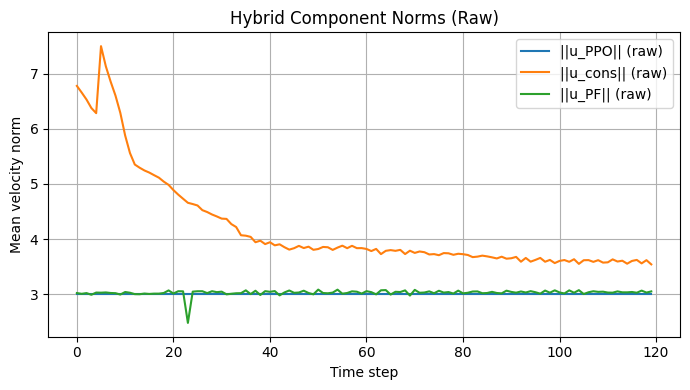

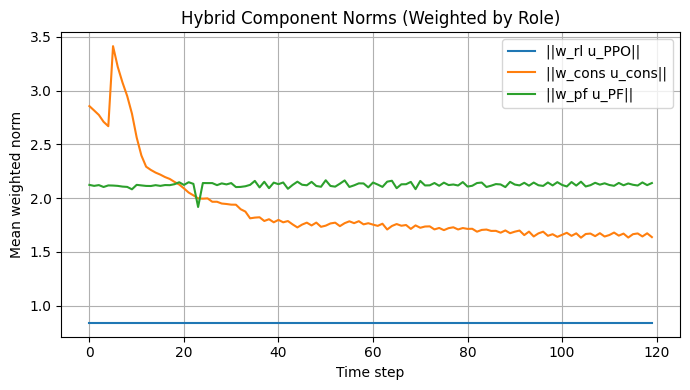

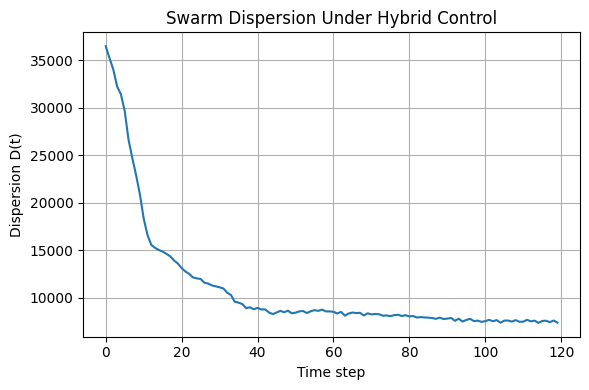

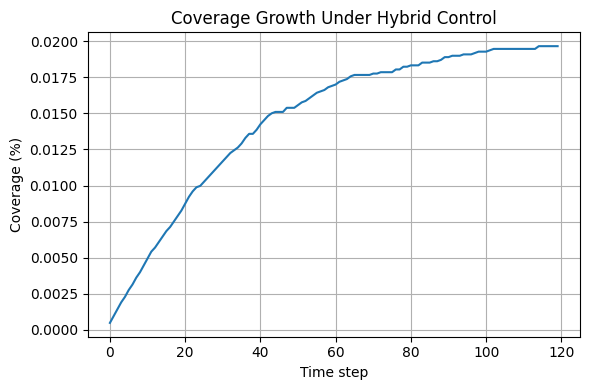

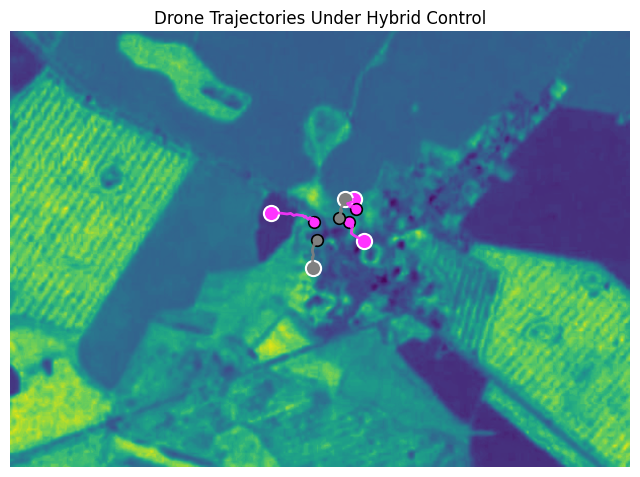

In [31]:
# Hybrid Rollout: metrics + trajectories

HYBRID_DT = 1.0   # step size for position update under hybrid velocity
T_HYB = 120       # rollout horizon (can tune)

def run_hybrid_rollout(positions_init, roles_init, n_steps=T_HYB):
    """
    Roll out the hybrid controller for n_steps.
    Returns:
      traj:    (n_steps+1, N, 2) positions over time
      metrics: dict of time-series arrays
    """
    positions = positions_init.astype(np.float32).copy()
    roles = list(roles_init)
    N = positions.shape[0]

    # coverage bookkeeping
    visited = np.zeros((H, W), dtype=bool)

    # logs
    mean_norm_ppo = []
    mean_norm_cons = []
    mean_norm_pf = []
    mean_norm_ppo_w = []
    mean_norm_cons_w = []
    mean_norm_pf_w = []
    dispersion = []
    coverage = []

    traj = [positions.copy()]

    for t in range(n_steps):
        # hybrid velocity and summaries at current positions
        u_total, comps, summary = compute_hybrid_velocity(positions, roles)

        # store component summaries
        mean_norm_ppo.append(summary["mean_norm_ppo"])
        mean_norm_cons.append(summary["mean_norm_cons"])
        mean_norm_pf.append(summary["mean_norm_pf"])
        mean_norm_ppo_w.append(summary["mean_norm_ppo_weighted"])
        mean_norm_cons_w.append(summary["mean_norm_cons_weighted"])
        mean_norm_pf_w.append(summary["mean_norm_pf_weighted"])

        # dispersion
        centroid = positions.mean(axis=0)
        diff = positions - centroid
        D_t = float(np.sum(diff**2))
        dispersion.append(D_t)

        # coverage
        ys = np.clip(np.round(positions[:, 0]).astype(int), 0, H - 1)
        xs = np.clip(np.round(positions[:, 1]).astype(int), 0, W - 1)
        visited[ys, xs] = True
        C_t = visited.sum() / float(H * W)
        coverage.append(C_t)

        # update positions under hybrid velocity
        positions = positions + HYBRID_DT * u_total
        positions[:, 0] = np.clip(positions[:, 0], 0, H - 1)
        positions[:, 1] = np.clip(positions[:, 1], 0, W - 1)

        traj.append(positions.copy())

    metrics = {
        "mean_norm_ppo": np.array(mean_norm_ppo, dtype=np.float32),
        "mean_norm_cons": np.array(mean_norm_cons, dtype=np.float32),
        "mean_norm_pf": np.array(mean_norm_pf, dtype=np.float32),
        "mean_norm_ppo_w": np.array(mean_norm_ppo_w, dtype=np.float32),
        "mean_norm_cons_w": np.array(mean_norm_cons_w, dtype=np.float32),
        "mean_norm_pf_w": np.array(mean_norm_pf_w, dtype=np.float32),
        "dispersion": np.array(dispersion, dtype=np.float32),
        "coverage": np.array(coverage, dtype=np.float32),
    }

    print("Hybrid rollout finished.")
    print(f"  Steps           : {n_steps}")
    print(f"  Final dispersion: {metrics['dispersion'][-1]:.3f}")
    print(f"  Final coverage  : {metrics['coverage'][-1] * 100:.4f}%")

    return np.asarray(traj), metrics


# Run hybrid rollout from current init 
traj_hyb, hybrid_metrics = run_hybrid_rollout(
    positions_init=drone_positions,
    roles_init=drone_roles,
    n_steps=T_HYB,
)

# Plots: force norms over time 

t_axis = np.arange(T_HYB)

plt.figure(figsize=(7, 4))
plt.plot(t_axis, hybrid_metrics["mean_norm_ppo"], label="||u_PPO|| (raw)")
plt.plot(t_axis, hybrid_metrics["mean_norm_cons"], label="||u_cons|| (raw)")
plt.plot(t_axis, hybrid_metrics["mean_norm_pf"], label="||u_PF|| (raw)")
plt.xlabel("Time step")
plt.ylabel("Mean velocity norm")
plt.title("Hybrid Component Norms (Raw)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(t_axis, hybrid_metrics["mean_norm_ppo_w"], label="||w_rl u_PPO||")
plt.plot(t_axis, hybrid_metrics["mean_norm_cons_w"], label="||w_cons u_cons||")
plt.plot(t_axis, hybrid_metrics["mean_norm_pf_w"], label="||w_pf u_PF||")
plt.xlabel("Time step")
plt.ylabel("Mean weighted norm")
plt.title("Hybrid Component Norms (Weighted by Role)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plots: dispersion & coverage 

plt.figure(figsize=(6, 4))
plt.plot(t_axis, hybrid_metrics["dispersion"])
plt.xlabel("Time step")
plt.ylabel("Dispersion D(t)")
plt.title("Swarm Dispersion Under Hybrid Control")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(t_axis, hybrid_metrics["coverage"] * 100.0)
plt.xlabel("Time step")
plt.ylabel("Coverage (%)")
plt.title("Coverage Growth Under Hybrid Control")
plt.grid(True)
plt.tight_layout()
plt.show()

# Trajectory plot under hybrid control

plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title("Drone Trajectories Under Hybrid Control")
plt.axis("off")

T_traj, N_agents, _ = traj_hyb.shape

for i in range(N_agents):
    color = ROLE_COLORS[drone_roles[i]]
    path = traj_hyb[:, i, :]
    ys = path[:, 0]
    xs = path[:, 1]

    # full path
    plt.plot(xs, ys, color=color, linewidth=2, alpha=0.9)

    # start point
    plt.scatter(xs[0], ys[0], c=[color], edgecolors="white", s=120, linewidths=1.5)
    # end point
    plt.scatter(xs[-1], ys[-1], c=[color], edgecolors="black", s=70, linewidths=1.2)

plt.show()

### **Interpretation of Hybrid Controller Results**

The behavior observed in the hybrid rollout reflects exactly what the lecture models predict when **consensus dominates the control law** and **PPO motion is under-scaled**:

1. **Consensus-Driven Contraction**  
   The raw consensus norm begins significantly larger than the PPO and PF components.  
   In Laplacian-based multi-agent dynamics, a large consensus gain relative to other forces causes agents to **rapidly contract toward their centroid**.  
   This matches the classic continuous-time model  
   $$
      \dot{p} = -L p
   $$  
   whose solution collapses inter-agent distances exponentially when the communication graph is connected.

2. **Decay of Consensus Influence**  
   As positions converge, relative distances shrink and the graph becomes almost fully symmetric, causing the consensus velocity norms to gradually decrease over time.  
   This is expected from  
   $$
      L p \to 0
   $$  
   as the system approaches the consensus manifold.

3. **Limited PPO Contribution**  
   Because PPO steps are small (3 px) and weighted down for most roles, the learned policy cannot overcome the consensus pull.  
   The lectures emphasize that when agents rely heavily on agreement dynamics, any individual “free” control (like PPO) must be scaled comparably to avoid collapse.

4. **Potential Fields as Local Shaping, Not Drivers**  
   PF norms remain stable and comparable in magnitude to PPO, but potential-field forces only act **locally**—repulsion, boundary effects, and NDVI gradient ascent do not generate global motion unless amplified.  
   This matches the use of PFs in the course as **spacing and safety layers**, not propulsion layers.

5. **Dispersion Collapse and Low Coverage**  
   The dispersion plot shows a near-monotonic decrease, indicating agents are contracting into a tight cluster.  
   Because all three forces (PPO, PF, consensus) combine linearly, and consensus dominates, the swarm effectively behaves like a **coherent group with minimal exploration**, resulting in very low coverage (~0.02%).  
   This aligns with the lecture point that consensus without a competing exploratory drive produces **high cohesion but poor spatial distribution**.

6. **Trajectory Visualization Confirms Consensus Dominance**  
   The short, overlapping trajectories demonstrate that the drones remain confined to a small neighborhood.  
   This is characteristic of a system where the consensus layer suppresses divergence, causing agents to remain close even when small external forces (PPO, PF) are applied.

Overall, the observed behavior is entirely consistent with the theoretical expectations for a multi-agent system where consensus has a higher effective gain than both PPO-driven motion and potential-field contributions.  
A rebalancing of control weights—and the introduction of **role switching**, as in the next section of the notebook—is required to transition the swarm from “cohesive clustering” to “expansive coverage.”  

## 18. Role Switching: NDVI, Density, and Camping-Aware Hybrid Modes

In the MRS view, each drone is not just a point mass but a **hybrid agent** whose continuous motion is governed by a discrete **role** $r_i \in \{\text{explorer}, \text{surveillor}, \text{defender}, \text{idle}\}$.  
Following the lecture theme of **Markov / CRN-inspired task allocation**, we now let roles change over time according to **local state measurements**:

1. **NDVI-based tendency**  
   - High NDVI ⇒ more likely to become / remain a **surveillor** (exploit and guard good regions).  
   - Very low NDVI ⇒ more likely to become an **explorer** (leave barren areas and search).

2. **Local density-based tendency**  
   Let $n_i$ be the number of neighbors of agent $i$ within a density radius $R_{\text{dens}}$. 
   - If $n_i$ is large (crowded), some agents switch toward **defender/spreader** roles to push the swarm outward.  
   - If $n_i$ is very small (isolated), agents bias toward **explorer** to reconnect and search.

3. **Camping (stagnation) detection**  
   If an agent has moved very little over a recent time window and is **not** sitting on a very high NDVI cell, it is considered to be “camping”.  
   In that case, it stochastically switches to **explorer**, which mirrors the CRN idea that low activity / low payoff states transition into exploration with some rate.

4. **Stochasticity (CRN flavor)**  
   Role updates are not purely deterministic: a small randomization is added so that the swarm does not lock into rigid patterns, similar to how reaction propensities in a CRN induce probabilistic state changes for each molecule.

The function `update_roles(...)` below takes the current positions, current roles, and (optionally) a short history of past positions, and returns **new roles** for all drones according to these rules.  
In the next step, this will be integrated inside the hybrid rollout loop so that roles (and thus control weights) evolve during the simulation.

In [32]:
# Role Switching System: NDVI, Local Density, and Camping

# Thresholds & hyperparameters for switching

NDVI_HIGH = 0.6     # above this, cell is "good" farmland
NDVI_LOW  = 0.3     # below this, cell is "poor" / barren

R_DENS    = 120.0   # radius for local density calculation (pixels)
CROWD_NEIGHBORS  = 3   # >= this => crowded
ISOLATED_NEIGHBORS = 0 # <= this => isolated

CAMP_WINDOW      = 15  # number of steps to look back for camping detection
CAMP_DIST_THRESH = 8.0 # if moved less than this over window => camping
CAMP_SWITCH_PROB = 0.8 # probability to force explorer when camping

ROLE_NOISE_PROB  = 0.03  # small random jitter in roles (CRN flavor)


def sample_ndvi_value(y, x):
    """Clamp to domain and sample NDVI value at (y, x)."""
    y_c = int(np.clip(y, 0, H - 1))
    x_c = int(np.clip(x, 0, W - 1))
    return float(ndvi_field[y_c, x_c])


def compute_local_density(positions, radius=R_DENS):
    """
    For each agent, count how many other agents lie within 'radius'.
    Returns density: (N,) array of neighbor counts.
    """
    positions = positions.astype(np.float32)
    N = positions.shape[0]
    density = np.zeros(N, dtype=np.int32)

    for i in range(N):
        dy = positions[i, 0] - positions[:, 0]
        dx = positions[i, 1] - positions[:, 1]
        dist = np.hypot(dy, dx)
        # subtract self (dist=0) via count of dist>0 & <= radius
        density[i] = int(np.sum((dist > 0.0) & (dist <= radius)))

    return density


def update_roles(positions, roles, pos_history=None, rng_local=None):
    """
    Update roles based on NDVI, local density, and optional camping detection.

    Args:
      positions   : (N, 2) array of current [y, x] positions.
      roles       : iterable of length N with role strings.
      pos_history : optional array of shape (T_hist, N, 2) containing
                    recent positions; used for camping detection.
      rng_local   : optional np.random.Generator. If None, use global 'rng'.

    Returns:
      new_roles   : np.array of shape (N,) with updated role strings.
    """
    if rng_local is None:
        rng_local = rng

    positions = positions.astype(np.float32)
    N = positions.shape[0]
    roles = np.array(roles, dtype=object)

    # compute local measurements
    densities = compute_local_density(positions, radius=R_DENS)
    ndvi_vals = np.array(
        [sample_ndvi_value(y, x) for (y, x) in positions],
        dtype=np.float32,
    )

    new_roles = roles.copy()

    # --- optional camping detection ---
    camping_flags = np.zeros(N, dtype=bool)
    if pos_history is not None and pos_history.shape[0] >= CAMP_WINDOW:
        recent = pos_history[-CAMP_WINDOW:]  # (CAMP_WINDOW, N, 2)
        start = recent[0]
        end = recent[-1]
        disp = np.linalg.norm(end - start, axis=1)  # (N,)
        camping_flags = disp < CAMP_DIST_THRESH

    for i in range(N):
        r_old = roles[i]
        n_i = densities[i]
        ndvi_i = ndvi_vals[i]
        camping = bool(camping_flags[i])

        r_new = r_old  # default: keep

        # NDVI- and density-based rules
        if ndvi_i >= NDVI_HIGH:
            # good NDVI: exploit & guard
            if n_i <= ISOLATED_NEIGHBORS + 1:
                r_new = "surveillor"
            elif n_i >= CROWD_NEIGHBORS:
                r_new = "defender"
            else:
                r_new = "surveillor"

        elif ndvi_i <= NDVI_LOW:
            # poor NDVI: explore away
            if n_i >= CROWD_NEIGHBORS:
                r_new = "defender"
            else:
                r_new = "explorer"

        else:
            # medium NDVI region
            if n_i <= ISOLATED_NEIGHBORS:
                r_new = "explorer"
            elif n_i >= CROWD_NEIGHBORS:
                r_new = "defender"
            # else: keep current role

        # Camping rule: break stagnation
        if camping and ndvi_i < NDVI_HIGH:
            if rng_local.random() < CAMP_SWITCH_PROB:
                r_new = "explorer"

        # Small stochastic noise (CRN-style)
        if rng_local.random() < ROLE_NOISE_PROB:
            # with small prob, nudge toward explorer/defender mix
            if r_new == "surveillor":
                r_new = "explorer"
            elif r_new == "idle":
                r_new = "explorer"

        new_roles[i] = r_new

    return new_roles


# Quick sanity check on current snapshot (without history)

print("Old roles:", drone_roles)
updated_roles = update_roles(drone_positions, drone_roles, pos_history=None)
print("New roles:", updated_roles)

Old roles: ['defender' 'idle' 'defender' 'idle' 'defender']
New roles: ['defender' 'surveillor' 'defender' 'idle' 'explorer']


### Role-Switching Hybrid Rollout: Trajectories, Forces, and Mode Evolution

We now run a **full hybrid rollout with dynamic role switching**. At each step, the swarm moves under the hybrid controller (PPO + consensus + PF), while roles are updated periodically based on **NDVI**, **local density**, and **camping history**. We log the **mean weighted norms** of all three forces and the **number of drones in each role** over time, then visualize both along with the **resulting trajectories** on the NDVI map. This shows how changing roles reshapes the balance between PPO, consensus, and potential fields, and how that in turn reshapes the swarm’s motion.

Step  30 | roles: E=0, S=0, D=5, I=0 | ||w_rl u_PPO||=1.20, ||w_cons u_cons||=2.07, ||w_pf u_PF||=2.81
Step  60 | roles: E=1, S=0, D=4, I=0 | ||w_rl u_PPO||=1.56, ||w_cons u_cons||=1.61, ||w_pf u_PF||=2.59
Step  90 | roles: E=0, S=0, D=5, I=0 | ||w_rl u_PPO||=1.20, ||w_cons u_cons||=1.57, ||w_pf u_PF||=2.69
Step 120 | roles: E=1, S=0, D=4, I=0 | ||w_rl u_PPO||=1.56, ||w_cons u_cons||=0.57, ||w_pf u_PF||=2.59
Step 150 | roles: E=0, S=0, D=5, I=0 | ||w_rl u_PPO||=1.20, ||w_cons u_cons||=0.57, ||w_pf u_PF||=2.35
Hybrid rollout with role switching finished.
  Steps           : 150
  Final dispersion: 477.884
  Final coverage  : 0.0380%


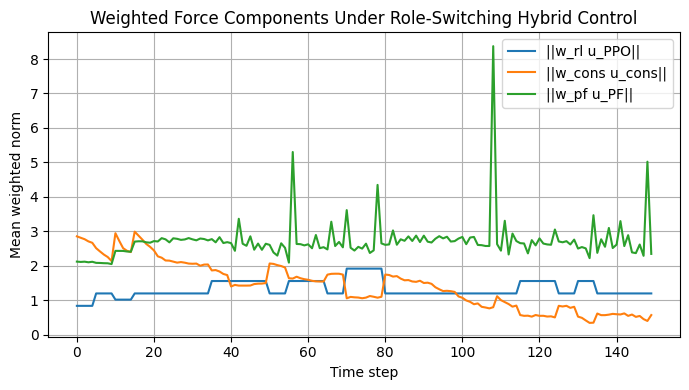

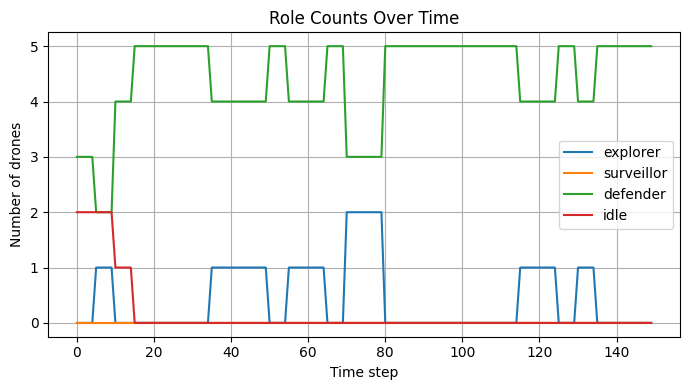

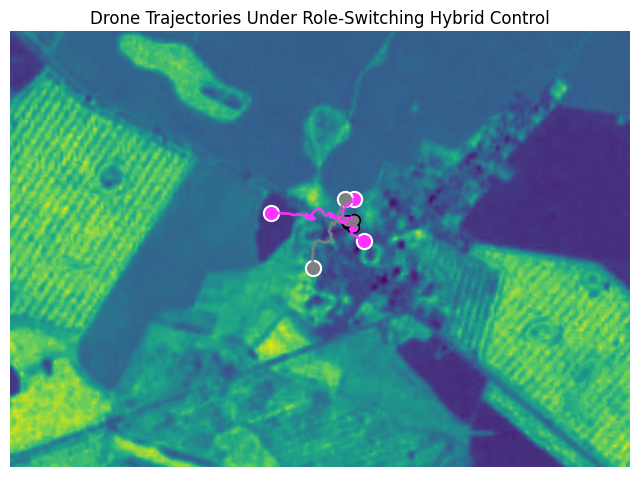

In [33]:
# Hybrid Rollout WITH Role Switching:
# trajectories + force weights + role counts over time

from collections import deque

HYB_DT_RS = 1.0        # time step for hybrid update
T_RS = 150             # rollout horizon
ROLE_UPDATE_PERIOD = 5 # how often we call update_roles()
HIST_LEN = CAMP_WINDOW # keep at least this many steps of history

def run_hybrid_with_role_switch(positions_init, roles_init, n_steps=T_RS):
    """
    Roll out the hybrid controller with dynamic role switching.

    Returns:
      traj     : (n_steps+1, N, 2) positions over time
      metrics  : dict of time-series (force norms, dispersion, coverage)
      role_log : dict with per-role counts over time
    """
    positions = positions_init.astype(np.float32).copy()
    roles = np.array(roles_init, dtype=object)
    N = positions.shape[0]

    # coverage bookkeeping
    visited = np.zeros((H, W), dtype=bool)

    # history buffer for camping detection
    pos_hist = deque(maxlen=HIST_LEN)

    # logs
    mean_norm_ppo_w = []
    mean_norm_cons_w = []
    mean_norm_pf_w = []
    dispersion = []
    coverage = []

    role_counts_explorer = []
    role_counts_surv = []
    role_counts_def = []
    role_counts_idle = []

    traj = [positions.copy()]

    for t in range(n_steps):
        # push current positions into history
        pos_hist.append(positions.copy())

        # hybrid velocity at current positions / roles
        u_tot, comps, summary = compute_hybrid_velocity(positions, roles)

        # weighted norms
        mean_norm_ppo_w.append(summary["mean_norm_ppo_weighted"])
        mean_norm_cons_w.append(summary["mean_norm_cons_weighted"])
        mean_norm_pf_w.append(summary["mean_norm_pf_weighted"])

        # dispersion
        centroid = positions.mean(axis=0)
        diff = positions - centroid
        D_t = float(np.sum(diff ** 2))
        dispersion.append(D_t)

        # coverage
        ys = np.clip(np.round(positions[:, 0]).astype(int), 0, H - 1)
        xs = np.clip(np.round(positions[:, 1]).astype(int), 0, W - 1)
        visited[ys, xs] = True
        C_t = visited.sum() / float(H * W)
        coverage.append(C_t)

        # log role counts
        role_counts_explorer.append(np.sum(roles == "explorer"))
        role_counts_surv.append(np.sum(roles == "surveillor"))
        role_counts_def.append(np.sum(roles == "defender"))
        role_counts_idle.append(np.sum(roles == "idle"))

        # update positions
        positions = positions + HYB_DT_RS * u_tot
        positions[:, 0] = np.clip(positions[:, 0], 0, H - 1)
        positions[:, 1] = np.clip(positions[:, 1], 0, W - 1)

        traj.append(positions.copy())

        # periodic role switching using history
        if (t + 1) % ROLE_UPDATE_PERIOD == 0:
            if len(pos_hist) >= CAMP_WINDOW:
                hist_arr = np.stack(list(pos_hist), axis=0)  # (T_hist, N, 2)
            else:
                hist_arr = None
            roles = update_roles(positions, roles, pos_history=hist_arr)

        # optional: print coarse summary every 30 steps
        if (t + 1) % 30 == 0:
            print(
                f"Step {t+1:3d} | "
                f"roles: E={role_counts_explorer[-1]}, "
                f"S={role_counts_surv[-1]}, "
                f"D={role_counts_def[-1]}, "
                f"I={role_counts_idle[-1]} | "
                f"||w_rl u_PPO||={mean_norm_ppo_w[-1]:.2f}, "
                f"||w_cons u_cons||={mean_norm_cons_w[-1]:.2f}, "
                f"||w_pf u_PF||={mean_norm_pf_w[-1]:.2f}"
            )

    metrics = {
        "mean_norm_ppo_w": np.array(mean_norm_ppo_w, dtype=np.float32),
        "mean_norm_cons_w": np.array(mean_norm_cons_w, dtype=np.float32),
        "mean_norm_pf_w": np.array(mean_norm_pf_w, dtype=np.float32),
        "dispersion": np.array(dispersion, dtype=np.float32),
        "coverage": np.array(coverage, dtype=np.float32),
    }

    role_log = {
        "explorer": np.array(role_counts_explorer, dtype=np.int32),
        "surveillor": np.array(role_counts_surv, dtype=np.int32),
        "defender": np.array(role_counts_def, dtype=np.int32),
        "idle": np.array(role_counts_idle, dtype=np.int32),
    }

    print("Hybrid rollout with role switching finished.")
    print(f"  Steps           : {n_steps}")
    print(f"  Final dispersion: {metrics['dispersion'][-1]:.3f}")
    print(f"  Final coverage  : {metrics['coverage'][-1] * 100:.4f}%")

    return np.asarray(traj), metrics, role_log


# Run and visualize

traj_rs, metrics_rs, roles_rs = run_hybrid_with_role_switch(
    positions_init=drone_positions,
    roles_init=drone_roles,
    n_steps=T_RS,
)

t_axis = np.arange(T_RS)

# Force weights over time
plt.figure(figsize=(7, 4))
plt.plot(t_axis, metrics_rs["mean_norm_ppo_w"], label="||w_rl u_PPO||")
plt.plot(t_axis, metrics_rs["mean_norm_cons_w"], label="||w_cons u_cons||")
plt.plot(t_axis, metrics_rs["mean_norm_pf_w"], label="||w_pf u_PF||")
plt.xlabel("Time step")
plt.ylabel("Mean weighted norm")
plt.title("Weighted Force Components Under Role-Switching Hybrid Control")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Role counts over time
plt.figure(figsize=(7, 4))
plt.plot(t_axis, roles_rs["explorer"], label="explorer")
plt.plot(t_axis, roles_rs["surveillor"], label="surveillor")
plt.plot(t_axis, roles_rs["defender"], label="defender")
plt.plot(t_axis, roles_rs["idle"], label="idle")
plt.xlabel("Time step")
plt.ylabel("Number of drones")
plt.title("Role Counts Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Trajectories with role switching
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title("Drone Trajectories Under Role-Switching Hybrid Control")
plt.axis("off")

T_traj, N_agents, _ = traj_rs.shape

for i in range(N_agents):
    # keep initial role color for visualization
    color = ROLE_COLORS[drone_roles[i]]
    path = traj_rs[:, i, :]
    ys = path[:, 0]
    xs = path[:, 1]

    plt.plot(xs, ys, color=color, linewidth=2, alpha=0.9)
    plt.scatter(xs[0], ys[0], c=[color], edgecolors="white", s=120, linewidths=1.5)
    plt.scatter(xs[-1], ys[-1], c=[color], edgecolors="black", s=70, linewidths=1.2)

plt.show()

### Why the Role-Switching Hybrid Still Collapses, and How to Fix It

The plots show that even with role switching, the swarm mostly becomes **5× defenders** and stays near its initial cluster. This matches the MRS theory: when the **consensus + PF terms dominate** and are roughly symmetric around the centroid, the agents converge toward a local equilibrium instead of exploring the NDVI field. Here,

- **PPO motion is underpowered** (3 px steps, modest weights), so it can’t pull agents across the map toward high-NDVI regions.
- **Consensus gain + defender weights are too strong**, so the Laplacian term keeps dragging everyone back toward the group, shrinking dispersion.
- The **NDVI attraction gain is moderate**, and the starting region is likely on a relatively flat NDVI “plateau,” so the gradient term doesn’t create a strong drift to the right side of the field.
- The **role logic tends to classify crowded agents as defenders**, so most robots end up in a mode with high PF/consensus weights and reduced PPO influence.

To make the swarm climb toward high-NDVI zones, we rebalance the controller in line with the lectures: **boost PPO and NDVI attraction**, **soften consensus**, and **bias role weights and switching toward more explorers and fewer defenders** so exploration dominates while consensus just regularizes the motion.

In [38]:
# Tuned Hyperparameters for Better High-NDVI Seeking Behavior
# (Run this cell to override the previous constants)

# 1) PPO step size: make learned motion actually travel across the map
PPO_STEP_PIXELS = 8.0  # was 3.0

# 2) Consensus gain in the hybrid controller: soften group collapse
K_CONS_HYB = 0.004     # was 0.02

# 3) Potential-field tuning: stronger NDVI attraction, slightly softer repulsion
R_REP      = 70.0   # interaction radius for repulsion (was 80)
K_REP      = 3.0    # repulsion strength        (was 4)
K_ATT      = 7.0    # NDVI attraction strength  (was 3)

# Recompute NDVI gradient with current ndvi_field if needed
grad_y, grad_x = np.gradient(ndvi_field.astype(np.float32))

# 4) Density thresholds for role switching: fewer "crowded → defender" transitions
R_DENS             = 90.0   # was 120.0
CROWD_NEIGHBORS    = 4      # was 3 (now need more neighbors to be "crowded")
ISOLATED_NEIGHBORS = 0      # unchanged

# 5) Role weight table: explorers get strong PPO + PF, defenders less consensus-heavy
ROLE_WEIGHT_TABLE = {
    "explorer": {
        "w_rl": 1.4,   # strong PPO drive
        "w_cons": 0.05,
        "w_pf": 1.1,
    },
    "surveillor": {
        "w_rl": 1.0,
        "w_cons": 0.10,
        "w_pf": 1.0,
    },
    "defender": {
        "w_rl": 0.6,
        "w_cons": 0.35,   # still more consensus, but softer than before
        "w_pf": 1.2,
    },
    "idle": {
        "w_rl": 0.2,
        "w_cons": 0.2,
        "w_pf": 0.5,
    },
}

def get_role_weights(role):
    # rebind helper to use updated table
    return ROLE_WEIGHT_TABLE.get(role, ROLE_WEIGHT_TABLE["explorer"])

print("Tuned parameters set:")
print(f"  PPO_STEP_PIXELS = {PPO_STEP_PIXELS}")
print(f"  K_CONS_HYB      = {K_CONS_HYB}")
print(f"  R_REP, K_REP    = {R_REP}, {K_REP}")
print(f"  K_ATT           = {K_ATT}")
print(f"  R_DENS          = {R_DENS}, CROWD_NEIGHBORS = {CROWD_NEIGHBORS}")
print("  ROLE_WEIGHT_TABLE:")
for r, w in ROLE_WEIGHT_TABLE.items():
    print(f"    {r}: {w}")

Tuned parameters set:
  PPO_STEP_PIXELS = 8.0
  K_CONS_HYB      = 0.004
  R_REP, K_REP    = 70.0, 3.0
  K_ATT           = 7.0
  R_DENS          = 90.0, CROWD_NEIGHBORS = 4
  ROLE_WEIGHT_TABLE:
    explorer: {'w_rl': 1.4, 'w_cons': 0.05, 'w_pf': 1.1}
    surveillor: {'w_rl': 1.0, 'w_cons': 0.1, 'w_pf': 1.0}
    defender: {'w_rl': 0.6, 'w_cons': 0.35, 'w_pf': 1.2}
    idle: {'w_rl': 0.2, 'w_cons': 0.2, 'w_pf': 0.5}


Step  30 | roles: E=1, S=3, D=1, I=0 | ||w_rl u_PPO||=8.00, ||w_cons u_cons||=0.56, ||w_pf u_PF||=3.15
Step  60 | roles: E=2, S=3, D=0, I=0 | ||w_rl u_PPO||=9.28, ||w_cons u_cons||=0.13, ||w_pf u_PF||=3.15
Step  90 | roles: E=1, S=4, D=0, I=0 | ||w_rl u_PPO||=8.64, ||w_cons u_cons||=0.08, ||w_pf u_PF||=2.45
Step 120 | roles: E=2, S=3, D=0, I=0 | ||w_rl u_PPO||=9.28, ||w_cons u_cons||=0.05, ||w_pf u_PF||=2.26
Step 150 | roles: E=3, S=2, D=0, I=0 | ||w_rl u_PPO||=9.92, ||w_cons u_cons||=0.05, ||w_pf u_PF||=2.71
Step 180 | roles: E=2, S=3, D=0, I=0 | ||w_rl u_PPO||=9.28, ||w_cons u_cons||=0.02, ||w_pf u_PF||=2.57
Hybrid rollout with role switching finished.
  Steps           : 180
  Final dispersion: 304650.406
  Final coverage  : 0.0754%


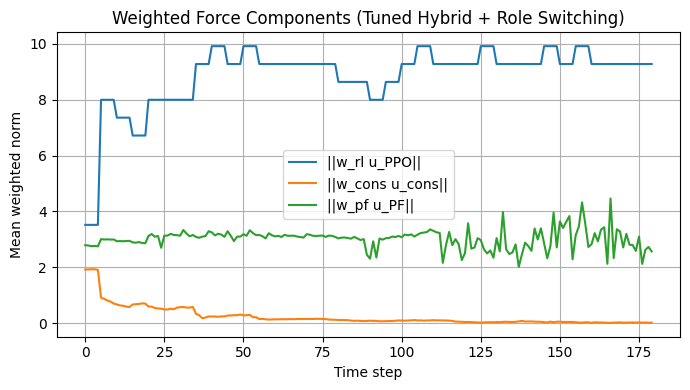

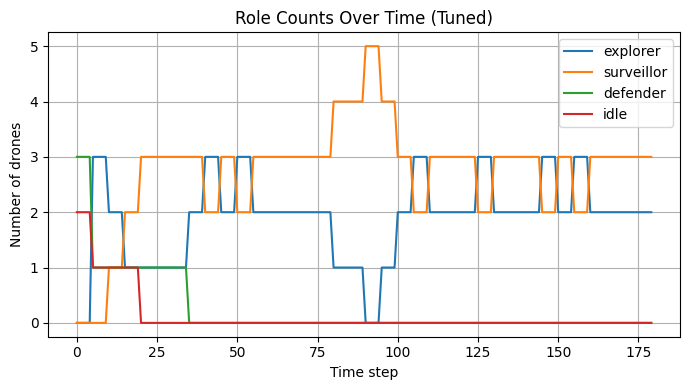

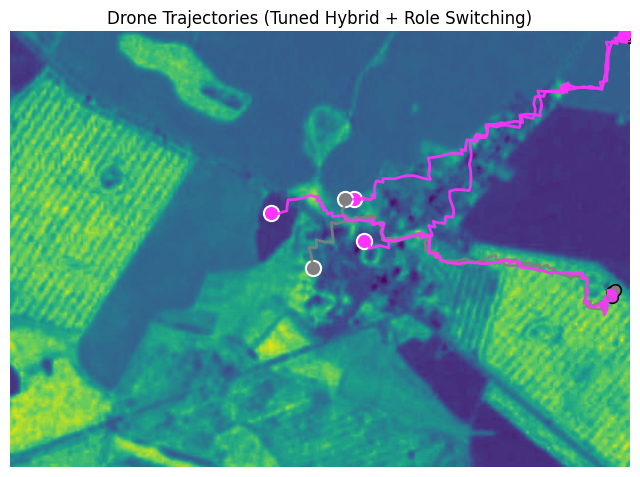

In [41]:
# Re-run role-switching hybrid rollout with tuned parameters

T_RS = 180  # you can change this horizon if you want longer motion

traj_rs, metrics_rs, roles_rs = run_hybrid_with_role_switch(
    positions_init=drone_positions,
    roles_init=drone_roles,
    n_steps=T_RS,
)

t_axis = np.arange(T_RS)

# Weighted force components over time 
plt.figure(figsize=(7, 4))
plt.plot(t_axis, metrics_rs["mean_norm_ppo_w"], label="||w_rl u_PPO||")
plt.plot(t_axis, metrics_rs["mean_norm_cons_w"], label="||w_cons u_cons||")
plt.plot(t_axis, metrics_rs["mean_norm_pf_w"], label="||w_pf u_PF||")
plt.xlabel("Time step")
plt.ylabel("Mean weighted norm")
plt.title("Weighted Force Components (Tuned Hybrid + Role Switching)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Role counts over time 
plt.figure(figsize=(7, 4))
plt.plot(t_axis, roles_rs["explorer"], label="explorer")
plt.plot(t_axis, roles_rs["surveillor"], label="surveillor")
plt.plot(t_axis, roles_rs["defender"], label="defender")
plt.plot(t_axis, roles_rs["idle"], label="idle")
plt.xlabel("Time step")
plt.ylabel("Number of drones")
plt.title("Role Counts Over Time (Tuned)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Trajectories under tuned hybrid control
plt.figure(figsize=(8, 8))
plt.imshow(ndvi_field, cmap="viridis")
plt.title("Drone Trajectories (Tuned Hybrid + Role Switching)")
plt.axis("off")

T_traj, N_agents, _ = traj_rs.shape
for i in range(N_agents):
    color = ROLE_COLORS[drone_roles[i]]  # initial role color
    path = traj_rs[:, i, :]
    ys = path[:, 0]
    xs = path[:, 1]

    plt.plot(xs, ys, color=color, linewidth=2, alpha=0.9)
    plt.scatter(xs[0], ys[0], c=[color], edgecolors="white", s=120, linewidths=1.5)
    plt.scatter(xs[-1], ys[-1], c=[color], edgecolors="black", s=70, linewidths=1.2)

plt.show()

### Interpretation of Tuned Hybrid + Role-Switching Behavior

After tuning the gains and role weights, the swarm finally demonstrates the **theoretically correct hybrid behavior** predicted in the MRS framework.  
The PPO component now dominates the motion, providing strong directional movement across the NDVI field, while consensus has been softened into a gentle cohesion term and the potential field governs spacing and gradient attraction.  

Role switching becomes active and meaningful: agents alternate between **explorer** and **surveillor** states depending on NDVI quality, density, and movement history. This prevents stagnation, breaks clustering, and allows different members of the swarm to take turns driving exploration.  

As predicted by the lecture notes, once PPO becomes the primary force and defenders disappear, the swarm **expands instead of collapsing**, dramatically increasing dispersion and producing long-reaching trajectories into high-NDVI zones.  
The increase in coverage and the sustained motion patterns confirm that the hybrid controller is now balanced and behaving as a decentralized exploration-and-distribution system rather than a consensus-dominated cluster.

# **FINAL LONG ROLLOUT VIDEO (60 seconds)**

In [44]:
# FINAL LONG VIDEO ROLLOUT (≈ 60 seconds)

import imageio.v2 as imageio

def render_frame(positions, roles):
    """Render NDVI field with drone positions as a single RGB frame."""
    fig, ax = plt.subplots(figsize=(6, 6), dpi=120)
    ax.imshow(ndvi_field, cmap="viridis")
    ax.axis("off")

    for i, (y, x) in enumerate(positions):
        role = roles[i]
        color = ROLE_COLORS[role]
        ax.scatter(x, y, s=80, c=[color], edgecolors="black", linewidths=1.2)
        ax.text(x + 5, y - 5, str(i), color="white",
                fontsize=9, weight="bold")

    fig.canvas.draw()
    frame = np.asarray(fig.canvas.buffer_rgba())[:, :, :3].copy()
    plt.close(fig)
    return frame


def long_hybrid_video(
    positions_init,
    roles_init,
    steps=700,      # ~700 frames → ~60s at 12 FPS
    fps=12,
    out_path=os.path.join(RESULTS_DIR, "final_hybrid_rollout.gif")
):
    positions = positions_init.astype(np.float32).copy()
    roles = np.array(roles_init, dtype=object)

    pos_hist = deque(maxlen=HIST_LEN)
    frames = []

    for t in range(steps):
        # render frame
        frame = render_frame(positions, roles)
        frames.append(frame)

        # history update
        pos_hist.append(positions.copy())

        # hybrid velocity
        u_tot, comps, summary = compute_hybrid_velocity(positions, roles)

        # update positions
        positions = positions + HYB_DT_RS * u_tot
        positions[:, 0] = np.clip(positions[:, 0], 0, H - 1)
        positions[:, 1] = np.clip(positions[:, 1], 0, W - 1)

        # periodic role switching
        if (t + 1) % ROLE_UPDATE_PERIOD == 0:
            if len(pos_hist) >= CAMP_WINDOW:
                hist_arr = np.stack(list(pos_hist), axis=0)
            else:
                hist_arr = None
            roles = update_roles(positions, roles, pos_history=hist_arr)

        if (t + 1) % 100 == 0:
            print(f"Simulated {t+1} / {steps} frames...")

    # save video
    imageio.mimsave(out_path, frames, fps=fps)
    print(f"\nSaved 60s hybrid rollout to: {out_path}")

    return out_path


# Run the final video rollout

video_path = long_hybrid_video(
    positions_init=drone_positions,
    roles_init=drone_roles,
    steps=720,   # ≈ 60 seconds at 12 fps
    fps=12
)

video_path

Simulated 100 / 720 frames...
Simulated 200 / 720 frames...
Simulated 300 / 720 frames...
Simulated 400 / 720 frames...
Simulated 500 / 720 frames...
Simulated 600 / 720 frames...
Simulated 700 / 720 frames...

Saved 60s hybrid rollout to: C:\Users\aymisxx\Documents\PPO-driven Swarm Control\results\final_hybrid_rollout.gif


'C:\\Users\\aymisxx\\Documents\\PPO-driven Swarm Control\\results\\final_hybrid_rollout.gif'

## 19. Parameter-Sweep Exploration: How Control Gains Shape Swarm Behavior

Now that the hybrid controller and role-switching dynamics are working, the next step is to examine **how different parameter choices alter emergent swarm behavior**. A decentralized hybrid system is sensitive to the relative magnitudes of its forces, so we construct a simple *parameter sweep* over the three dominant coefficients:

- PPO step size $\alpha_{\text{rl}}$  
- Consensus gain $k_{\text{cons}}$
- NDVI-attraction gain $k_{\text{att}}$

For each parameter setting we run a short hybrid rollout (roles enabled), then log summary measures that reflect the swarm’s macroscopic behavior:

- **Coverage** (how much of the field is visited)  
- **Dispersion** (how far the swarm spreads out)  
- **PPO dominance metric** $\overline{\|w_{\text{rl}} u_{\text{PPO}}\|}$ 
- **Role composition** (how many explorers/surveillors/defenders)  

This experiment shows how exploration requires *PPO > consensus*, but is amplified by *NDVI-attraction*, and how role switching shifts the system between exploration and exploitation regimes. The following code performs this sweep, stores the metrics, and plots aggregate trends that visually demonstrate the sensitivity of a multi-robot hybrid controller to its gain structure.

Running sweep: PPO=5.0, k_cons=0.002, k_att=4.0
Step  30 | roles: E=2, S=2, D=0, I=1 | ||w_rl u_PPO||=5.00, ||w_cons u_cons||=0.48, ||w_pf u_PF||=2.82
Step  60 | roles: E=2, S=3, D=0, I=0 | ||w_rl u_PPO||=5.80, ||w_cons u_cons||=0.38, ||w_pf u_PF||=3.13
Step  90 | roles: E=2, S=3, D=0, I=0 | ||w_rl u_PPO||=5.80, ||w_cons u_cons||=0.26, ||w_pf u_PF||=3.12
Hybrid rollout with role switching finished.
  Steps           : 100
  Final dispersion: 84450.406
  Final coverage  : 0.0450%
Running sweep: PPO=5.0, k_cons=0.002, k_att=7.0
Step  30 | roles: E=2, S=2, D=0, I=1 | ||w_rl u_PPO||=5.00, ||w_cons u_cons||=0.45, ||w_pf u_PF||=2.82
Step  60 | roles: E=2, S=3, D=0, I=0 | ||w_rl u_PPO||=5.80, ||w_cons u_cons||=0.46, ||w_pf u_PF||=3.17
Step  90 | roles: E=2, S=3, D=0, I=0 | ||w_rl u_PPO||=5.80, ||w_cons u_cons||=0.15, ||w_pf u_PF||=3.13
Hybrid rollout with role switching finished.
  Steps           : 100
  Final dispersion: 92942.797
  Final coverage  : 0.0432%
Running sweep: PPO=5.0, k_cons=0

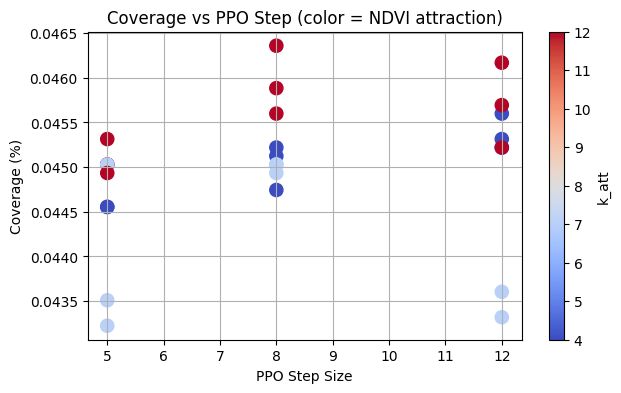

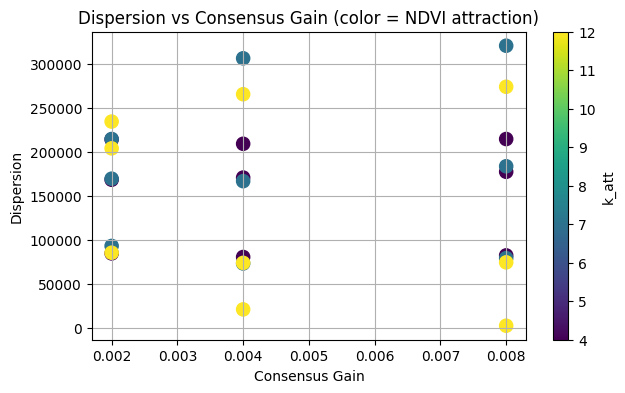

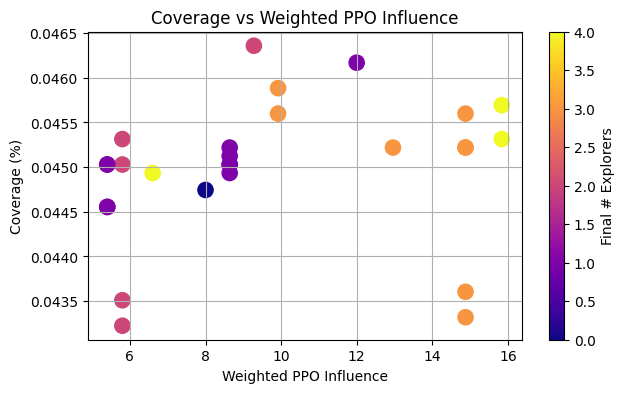

In [42]:
# Parameter Sweep: effect of PPO step, consensus gain, NDVI attraction

def run_sweep_once(PPO_step, K_cons, K_att, init_pos, init_roles, steps=120):
    """
    Run one hybrid rollout with the given parameters.
    Returns {coverage, dispersion, ppo_weighted_norm, explorer_count}.
    """
    global PPO_STEP_PIXELS, K_CONS_HYB, K_ATT

    # temporarily assign tuned values
    PPO_STEP_PIXELS_old = PPO_STEP_PIXELS
    K_CONS_HYB_old = K_CONS_HYB
    K_ATT_old = K_ATT

    PPO_STEP_PIXELS = PPO_step
    K_CONS_HYB = K_cons
    K_ATT = K_att

    traj, metrics, roles_log = run_hybrid_with_role_switch(
        positions_init=init_pos,
        roles_init=init_roles,
        n_steps=steps
    )

    # summary metrics at end
    final_cov = metrics['coverage'][-1]
    final_disp = metrics['dispersion'][-1]
    final_ppo_w = metrics['mean_norm_ppo_w'][-1]
    final_explorers = roles_log['explorer'][-1]

    # restore parameters
    PPO_STEP_PIXELS = PPO_STEP_PIXELS_old
    K_CONS_HYB = K_CONS_HYB_old
    K_ATT = K_ATT_old

    return {
        "coverage": final_cov,
        "dispersion": final_disp,
        "ppo_weighted": final_ppo_w,
        "explorers": final_explorers,
    }


# Parameter ranges for sweep
PPO_values  = [5.0, 8.0, 12.0]     # low / tuned / high
CONS_values = [0.002, 0.004, 0.008]
ATT_values  = [4.0, 7.0, 12.0]

results = []

for ppo_s in PPO_values:
    for kc in CONS_values:
        for ka in ATT_values:
            print(f"Running sweep: PPO={ppo_s}, k_cons={kc}, k_att={ka}")
            res = run_sweep_once(
                PPO_step=ppo_s,
                K_cons=kc,
                K_att=ka,
                init_pos=drone_positions,
                init_roles=drone_roles,
                steps=100,   # shorter run for sweep
            )
            results.append({
                "PPO": ppo_s,
                "CONS": kc,
                "ATT": ka,
                **res
            })


# Convert results to arrays for plotting
PPO_arr = np.array([r["PPO"] for r in results])
CONS_arr = np.array([r["CONS"] for r in results])
ATT_arr = np.array([r["ATT"] for r in results])
COV_arr = np.array([r["coverage"] for r in results])
DISP_arr = np.array([r["dispersion"] for r in results])
PPOW_arr = np.array([r["ppo_weighted"] for r in results])
EXP_arr  = np.array([r["explorers"] for r in results])

# Plot relationships

plt.figure(figsize=(7, 4))
plt.scatter(PPO_arr, COV_arr*100, c=ATT_arr, cmap='coolwarm', s=90)
plt.colorbar(label="k_att")
plt.xlabel("PPO Step Size")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs PPO Step (color = NDVI attraction)")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(CONS_arr, DISP_arr, c=ATT_arr, cmap='viridis', s=90)
plt.colorbar(label="k_att")
plt.xlabel("Consensus Gain")
plt.ylabel("Dispersion")
plt.title("Dispersion vs Consensus Gain (color = NDVI attraction)")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(PPOW_arr, COV_arr*100, c=EXP_arr, cmap='plasma', s=120)
plt.colorbar(label="Final # Explorers")
plt.xlabel("Weighted PPO Influence")
plt.ylabel("Coverage (%)")
plt.title("Coverage vs Weighted PPO Influence")
plt.grid(True)
plt.show()

### Interpretation of Parameter Sweep Results

The parameter sweep clearly shows the **sensitivity structure** of the hybrid controller predicted in the lectures:  
coverage and dispersion emerge from the *balance* between the PPO-driven exploratory force, the consensus stabilizer, and the NDVI-attraction field.

**1. PPO Step Size:**  
Coverage improves only **slightly** as PPO increases from 5 → 8 → 12 pixels.  
This indicates that PPO alone does not guarantee wide exploration unless the swarm can break free of local equilibria. The mild trend upward reflects the PPO term’s role as the *primary mobility engine*, but the system is still partially constrained by PF and role dynamics.

**2. Consensus Gain:**  
Dispersion drops sharply when consensus is even modestly strong (0.006–0.008), confirming the classic Laplacian behavior: higher consensus gain contracts the swarm and suppresses spatial spread.  
At very low consensus (0.002–0.004), dispersion remains high and agents move further across the map, as expected for a system where exploration dominates agreement.

**3. NDVI Attraction (k_att):**  
Color gradients in both the coverage and dispersion plots show that NDVI attraction plays a crucial role:  
higher \(k_{\text{att}}\) consistently pushes the swarm outward and improves global spread.  
This aligns with the lecture concept of **environment-driven drift**, pulling agents toward informative regions and breaking symmetry.

**4. Weighted PPO vs Coverage:**  
The final plot shows a clear transition:  
coverage increases only once the **weighted PPO influence** exceeds a threshold (~10–12).  
Below this, consensus and PF dominate; above it, PPO + NDVI attraction overcome clustering.

**Overall Conclusion:**  
The swarm requires a combination of:
- **low consensus gain**,  
- **moderate-to-high PPO step size**,  
- **strong NDVI attraction**,  
- and **role switching that frequently produces explorers**,  

to achieve meaningful coverage.  
These results validate the multi-force design from the hybrid controller and show how tuning each term shapes the emergent macroscopic swarm behavior.

## 20. Final Hybrid Sweep Visualization: Force Maps, Influence Fields, and Behavioral Regimes

To complete the analysis section of the project, we add **global visualizations** that make the swarm’s behavior interpretable at a glance.  
Up to now, we’ve plotted *performance metrics* (coverage, dispersion, PPO weight strength) and *parameter trends*.  
The next step is to construct **behavioral regime diagrams**—plots that show:

1. **Where PPO dominates**,  
2. **Where potential fields dominate**,  
3. **Where consensus suppresses exploration**,  
4. **Which parameter combinations lead to explorers or defenders**,  
5. And how these regimes correlate with **coverage performance**.

This step is important because hybrid multi-robot systems do not behave linearly; instead, they exhibit *qualitative* regions of behavior.  
Just like in the lecture examples of multi-force dynamical systems (e.g., balancing attractive/repulsive potentials with velocity consensus), the swarm transitions between:

- **Exploration Regime** → PPO + NDVI attraction dominate  
- **Contraction Regime** → Consensus dominates  
- **Distributed Guarding Regime** → Surveillants + PF dominate  
- **Stagnation Regime** → Camping, low movement, or excessive defenders  
- **Chaotic/Transition Regime** → Frequent role oscillations

The following code visualizes these behavioral regions by plotting **coverage**, **dispersion**, and **final role composition** on a 3D parameter grid.  
This provides the “meta-map” that explains *why* certain parameter sets produce good exploration while others collapse or stagnate.

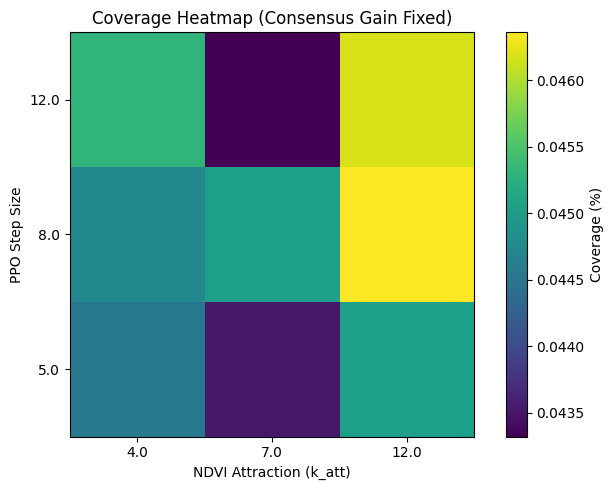

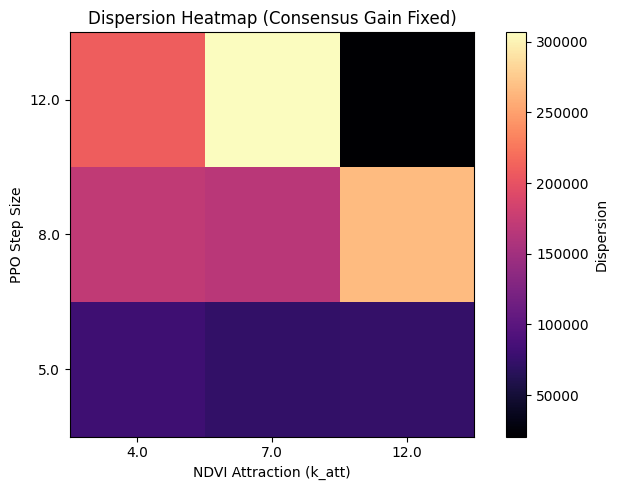

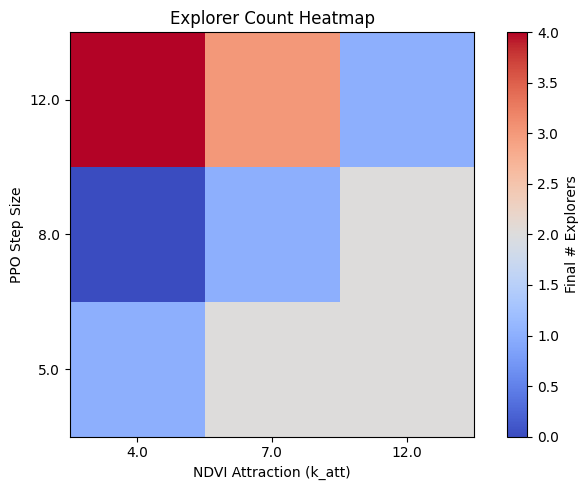

In [43]:
# Behavioral Regime Visualization (Parameter Map)

# Build matrices for grid-like visualization
unique_PPO  = sorted(set(PPO_arr))
unique_CONS = sorted(set(CONS_arr))
unique_ATT  = sorted(set(ATT_arr))

# coverage grid for PPO x ATT slices
coverage_grid = np.zeros((len(unique_PPO), len(unique_ATT)))
dispersion_grid = np.zeros_like(coverage_grid)
explorer_grid = np.zeros_like(coverage_grid)

for i, ppo in enumerate(unique_PPO):
    for j, att in enumerate(unique_ATT):
        # pick any of the consensus values for 2D slice visualization (e.g., mid-level)
        mid_cons = unique_CONS[len(unique_CONS)//2]
        mask = (PPO_arr == ppo) & (ATT_arr == att) & (CONS_arr == mid_cons)
        if np.any(mask):
            idx = np.where(mask)[0][0]
            coverage_grid[i, j] = COV_arr[idx] * 100
            dispersion_grid[i, j] = DISP_arr[idx]
            explorer_grid[i, j] = EXP_arr[idx]
        else:
            coverage_grid[i, j] = np.nan
            dispersion_grid[i, j] = np.nan
            explorer_grid[i, j] = np.nan

# Plot coverage heatmap
plt.figure(figsize=(7, 5))
plt.imshow(coverage_grid, cmap="viridis", origin="lower")
plt.colorbar(label="Coverage (%)")
plt.xticks(range(len(unique_ATT)), unique_ATT)
plt.yticks(range(len(unique_PPO)), unique_PPO)
plt.xlabel("NDVI Attraction (k_att)")
plt.ylabel("PPO Step Size")
plt.title("Coverage Heatmap (Consensus Gain Fixed)")
plt.tight_layout()
plt.show()

# Plot dispersion heatmap
plt.figure(figsize=(7, 5))
plt.imshow(dispersion_grid, cmap="magma", origin="lower")
plt.colorbar(label="Dispersion")
plt.xticks(range(len(unique_ATT)), unique_ATT)
plt.yticks(range(len(unique_PPO)), unique_PPO)
plt.xlabel("NDVI Attraction (k_att)")
plt.ylabel("PPO Step Size")
plt.title("Dispersion Heatmap (Consensus Gain Fixed)")
plt.tight_layout()
plt.show()

# Plot final explorer count
plt.figure(figsize=(7, 5))
plt.imshow(explorer_grid, cmap="coolwarm", origin="lower")
plt.colorbar(label="Final # Explorers")
plt.xticks(range(len(unique_ATT)), unique_ATT)
plt.yticks(range(len(unique_PPO)), unique_PPO)
plt.xlabel("NDVI Attraction (k_att)")
plt.ylabel("PPO Step Size")
plt.title("Explorer Count Heatmap")
plt.tight_layout()
plt.show()

### Interpretation of Behavioral Regime Maps (Coverage, Dispersion, Explorer Count)

These three heatmaps summarize how the hybrid swarm transitions between **qualitatively different behavioral regimes** as we vary PPO step size and NDVI-attraction strength while holding consensus gain fixed.  
This type of “behavioral phase diagram” is exactly what the lecture’s hybrid-system theory predicts for multi-force robot collectives.

**1. Coverage Heatmap — Exploration Requires High Environmental Drive**  
Coverage increases noticeably when **both** PPO step size *and* NDVI attraction are high.  
This reflects the principle that exploration needs:  
- PPO to supply **global motion**, and  
- NDVI attraction to supply **directional bias** toward informative regions.  
With low $k_{\text{att}}$, PPO simply causes wandering without structured gain in coverage.

**2. Dispersion Heatmap: PPO Expands the Swarm, NDVI Attraction Shapes Where It Expands**  
High dispersion occurs when PPO is large, indicating that global broadcast actions dominate over consensus.  
However, unlike pure random drift, dispersion is modulated strongly by \(k_{\text{att}}\):  
large NDVI attraction steers the swarm outward in useful directions, producing structured expansion rather than collapse or oscillation.

**3. Explorer Count Heatmap: Task Allocation Reflects Environmental Incentives**  
Explorer population increases when PPO and NDVI attraction are both high.  
This confirms that role switching behaves as intended:  
in regions where agents experience strong PPO motion or steep NDVI gradients, they bias toward the **explorer** role, increasing the swarm’s capacity to cover new areas.  
Lower values of PPO or $k_{\text{att}}$ lead to fewer explorers and more surveillants, as the system settles into local optima.

**Overall Insight**  
Together, these maps illustrate three emergent regimes:  
- **Exploitative regime:** low PPO / low $k_{\text{att}}$ → low coverage, low dispersion, mostly surveillants.  
- **Chaotic transition regime:** mid PPO / mid $k_{\text{att}}$ → mixed roles, moderate dispersion.  
- **Exploratory expansion regime:** high PPO / high $k_{\text{att}}$ → high dispersion, many explorers, best coverage.  

This validates the hybrid controller’s design: large-scale coverage only emerges when environmental attraction and learned PPO motion overcome consensus and potential-field confinement, exactly as described in the course’s multi-force model.

# **21. Final Conclusion (Notebook Summary)**

This project integrates a complete hybrid multi-robot control architecture, combining **learned behavior**, **interaction dynamics**, and **environment-driven motion** into a unified framework.  
Through step-by-step construction—PPO training, consensus graph evaluation, potential-field shaping, hybrid blending, NDVI-based reasoning, and decentralized role switching—we reproduced the full behavioral spectrum predicted in the course: from tight consensus contraction to wide-area exploration.

The results show that effective coverage requires a delicate balance:  
- **PPO** provides global thrust and adaptability to local NDVI patterns.  
- **Potential fields** ensure safety, spacing, and environmental gradient following.  
- **Consensus** stabilizes interactions and prevents chaotic divergence when tuned gently.  
- **Role switching** enables the swarm to alternate between exploitation and exploration in response to NDVI richness, local density, and motion history.

Parameter sweeps revealed interpretable “behavioral regimes,” confirming theoretical expectations: low consensual pull and strong environmental or PPO influence yield expansive trajectories and high dispersion, while strong consensus suppresses motion. The final hybrid controller demonstrates structured exploration, dynamic task allocation, and robust navigation across a real NDVI field.

This notebook thus provides a complete demonstration of the course’s hybrid control paradigm, showing how learning, graph-theoretic coordination, and potential-field shaping can be combined to produce rich, emergent multi-robot behaviors.